In [1]:
import warnings
warnings.filterwarnings("ignore")
import string
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from tqdm import tqdm
import random
import re
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.neural_network import MLPClassifier

from utils import get_selected_features

In [2]:
pd.set_option('display.max_columns', None)

<h3/>Function for Collecting URL Links from Basketball-Reference for All NBA Player Statistics

In [17]:
BASE_URL = "https://www.basketball-reference.com"
PLAYERS_LIST_URL = f"{BASE_URL}/players/"

def get_all_players():
    players = []
    
    for letter in tqdm(string.ascii_lowercase, desc="Prikupljam listu igrača"):
        url = f"{PLAYERS_LIST_URL}{letter}/"
        response = requests.get(url)
        response.encoding = 'utf-8'
        soup = BeautifulSoup(response.text, "html.parser")

        for row in soup.select("#players tr:not(.thead) th a"):
            if row:
                 players.append((row.text, BASE_URL + row["href"]))
    
    return players

players = get_all_players()
players_df = pd.DataFrame(players, columns=["Player","URL"])
players_df.to_csv("data/players.csv", index=False, encoding="utf-8-sig")

Prikupljam listu igrača: 100%|██████████| 26/26 [00:38<00:00,  1.49s/it]


In [19]:
len(players)

5313

In [4]:
df = df[df['Season'] >= '1981-82']

In [5]:
len(df['ID'].unique())

3598

<h3>Functions for Extracting and Cleaning Player Statistics:</h3>
<p>1. Extracting player statistics from the <b>Per game</b>, <b>Advanced</b> and <b>Total</b> tables, as well as his height and weight</p>
<p>2. Removing rows corresponding to seasons in which the player did not play (rows containing <b>'Did not play'</b> value in statistical columns)</p>
</p>3. Removing aggregate rows that do not represent individual player statistics per season
</p>4. Removing duplicate and extra rows for players who played for multiple teams in a single season

In [21]:
headers_list = [
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.83 Safari/537.36",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36",
]

def get_player_stats_in_html(name, player_url, retries=3):
    for i in range(retries):
        try:
            headers = {"User-Agent": random.choice(headers_list)}
            time.sleep(random.uniform(3, 6))
            response = requests.get(player_url, headers=headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, "html.parser")
            return soup
        except requests.exceptions.RequestException as e:
            print(f"Greška za {name}, pokušaj {i+1}/{retries}: {e}")
            time.sleep(10)
    return None

def get_player_height_and_weight(soup):
    p_tags = soup.find_all("p")

    height, weight = None, None

    for p in p_tags:
        match = re.search(r"\((\d+)cm,\s*(\d+)kg\)", p.text)
        if match:
            height, weight = match.groups()
            break
    return height, weight

def get_player_all_statistics(soup):
    table_per_game = soup.find("table", {"id": "per_game_stats"})
    table_advanced = soup.find("table", {"id": "advanced"})
    table_totals = soup.find("table", {"id": "totals_stats"})
    
    df = pd.read_html(str(table_per_game))[0] if table_per_game else None
    df_adv = pd.read_html(str(table_advanced))[0] if table_advanced else None
    df_totals = pd.read_html(str(table_totals))[0] if table_totals else None
    
    if df is not None and isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(0)
    if df_adv is not None and isinstance(df_adv.columns, pd.MultiIndex):
        df_adv.columns = df_adv.columns.droplevel(0)
    if df_totals is not None and isinstance(df_totals.columns, pd.MultiIndex):
        df_totals.columns = df_totals.columns.droplevel(0)
    
    if df_adv is not None:
        common_cols = ["Age", "Team", "Lg", "Pos", "G", "GS", "MP", "Awards"]
        df_adv = df_adv.drop(columns=[col for col in common_cols if col in df_adv.columns])
        df = df.merge(df_adv, on="Season", how="left")
    
    if df_totals is not None and 'Trp-Dbl' in df_totals.columns:
        df = df.merge(df_totals[['Season', 'Trp-Dbl']], on='Season', how='left')
    return df

def clean_player_stats(df):
    df_clean = df[~df['Age'].str.contains(r'^Did not play', na=False)]
    df_clean = df_clean[df_clean["Season"].str.match(r"^\d{4}-\d{2}$", na=False)]
    df_clean['Team'] = df_clean.groupby(['Season'])['Team'].transform(lambda x: ', '.join(x.unique()))
    df_clean = df_clean.drop_duplicates(subset=['Season'], keep='first')
    return df_clean

In [ ]:
def get_player_stats(name, player_url, player_id):
    
    soup = get_player_stats_in_html(name, player_url)
    if soup is None:
        print(f"Greška za {name}, vraćen je None")
        return None
    
    height, weight = get_player_height_and_weight(soup)
    
    df = get_player_all_statistics(soup)
    
    df = clean_player_stats(df)
    
    df.insert(0, "ID", player_id)
    df.insert(1, "Player", name)
    df.insert(2, "Height", height)
    df.insert(3, "Weight", weight)
    
    columns = [col for col in df.columns if col != "Awards"]
    df = df[columns + ["Awards"]]
    
    return df

<h3>Calling the Defined Functions and Creating the Initial Dataset

In [23]:
nba_player_stats = []
current_id = 1

for name, url in tqdm(players, desc="Prikupljam statistike igrača"):
    stats = get_player_stats(name, url, current_id)
    current_id += 1

    if stats is not None:
        nba_player_stats.append(stats)

        stats.to_csv("data/nba_player_stats_partial.csv", mode="a", header=not os.path.exists("data/nba_players_stats_partial.csv"), index=False, encoding="utf-8-sig")

if nba_player_stats:
    final_df = pd.concat(nba_player_stats, ignore_index=True)
    final_df.to_csv("data/nba_player_stats.csv", index=False, encoding="utf-8-sig")
    print("Podaci su uspešno sačuvani u 'nba_player_stats'!")

Prikupljam statistike igrača:  95%|█████████▍| 5029/5313 [8:56:34<44:36,  9.42s/it]  

Greška za Hubie White, pokušaj 1/3: 504 Server Error: Gateway Timeout for url: https://www.basketball-reference.com/players/w/whitehu01.html


Prikupljam statistike igrača:  95%|█████████▍| 5041/5313 [8:59:50<37:33,  8.29s/it]  

Greška za Willie White, pokušaj 1/3: 403 Client Error: Forbidden for url: https://www.basketball-reference.com/players/w/whitewi01.html
Greška za Willie White, pokušaj 2/3: 403 Client Error: Forbidden for url: https://www.basketball-reference.com/players/w/whitewi01.html
Greška za Willie White, pokušaj 3/3: 403 Client Error: Forbidden for url: https://www.basketball-reference.com/players/w/whitewi01.html


Prikupljam statistike igrača:  95%|█████████▍| 5042/5313 [9:00:38<1:32:05, 20.39s/it]

Greška za Willie White, vraćen je None


Prikupljam statistike igrača: 100%|██████████| 5313/5313 [9:32:09<00:00,  6.46s/it]  


Podaci su uspešno sačuvani u 'nba_player_stats_corrected_names'!


In [79]:
df = pd.read_csv("data/nba_player_stats.csv", low_memory=False)
df.describe()

ID        Height        Weight           Age             G  \
count  26385.000000  26379.000000  26379.000000  26369.000000  26385.000000   
mean    2617.502937    199.267069     95.866371     26.392772     54.388023   
std     1536.541893      9.199748     11.927247      3.906936     25.170942   
min        1.000000    160.000000     51.000000     18.000000      1.000000   
25%     1272.000000    193.000000     86.000000     23.000000     36.000000   
50%     2600.000000    201.000000     95.000000     26.000000     62.000000   
75%     3945.000000    206.000000    104.000000     29.000000     76.000000   
max     5313.000000    231.000000    163.000000     46.000000     90.000000   

                 GS            MP            FG           FGA           FG%  \
count  19843.000000  25593.000000  26385.000000  26385.000000  26295.000000   
mean      25.998236     20.809718      3.318302      7.421857      0.434614   
std       29.413001     10.272357      2.359376      4.926676      0.094850   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000     12.300000      1.500000      3.500000      0.397000   
50%       11.000000     20.200000      2.800000      6.300000      0.441000   
75%       52.000000     29.500000      4.700000     10.400000      0.483000   
max       84.000000     48.500000     20.000000     39.500000      1.000000   

                 3P           3PA           3P%            2P           2PA  \
count  21224.000000  21223.000000  18173.000000  22584.000000  22584.000000   
mean       0.485978      1.408236      0.260440      2.854946      5.935866   
std        0.678051      1.795232      0.168156      2.217033      4.412979   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.154000      1.100000      2.600000   
50%        0.100000      0.600000      0.306000      2.200000      4.700000   
75%        0.800000      2.300000      0.367000      4.000000      8.400000   
max        5.300000     13.200000      1.000000     14.300000     28.700000   

                2P%          eFG%            FT           FTA           FT%  \
count  22450.000000  22502.000000  26385.000000  26385.000000  25586.000000   
mean       0.469420      0.474167      1.700398      2.283544      0.724345   
std        0.099974      0.095633      1.507020      1.915413      0.137075   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.431000      0.439000      0.600000      0.900000      0.665000   
50%        0.474000      0.481000      1.200000      1.700000      0.748000   
75%        0.514000      0.520000      2.300000      3.100000      0.811000   
max        1.000000      1.500000     11.500000     17.000000      1.000000   

                ORB           DRB           TRB           AST           STL  \
count  22630.000000  22630.000000  25728.000000  26385.000000  21917.000000   
mean       1.079456      2.627742      3.871980      1.951632      0.685869   
std        0.900761      1.891414      2.879365      1.820344      0.482040   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.400000      1.300000      1.800000      0.700000      0.300000   
50%        0.800000      2.200000      3.100000      1.400000      0.600000   
75%        1.500000      3.500000      5.100000      2.600000      0.900000   
max        7.200000     13.700000     27.200000     14.500000      4.100000   

                BLK           TOV            PF           PTS           PER  \
count  21919.000000  21787.000000  26384.000000  26385.000000  25585.000000   
mean       0.423176      1.289723      2.029006      8.725950     12.846191   
std        0.507635      0.854960      0.904791      6.261427      5.994851   
min        0.000000      0.000000      0.000000      0.000000    -90.600000   
25%        0.100000      0.600000      1.400000      3.900000 

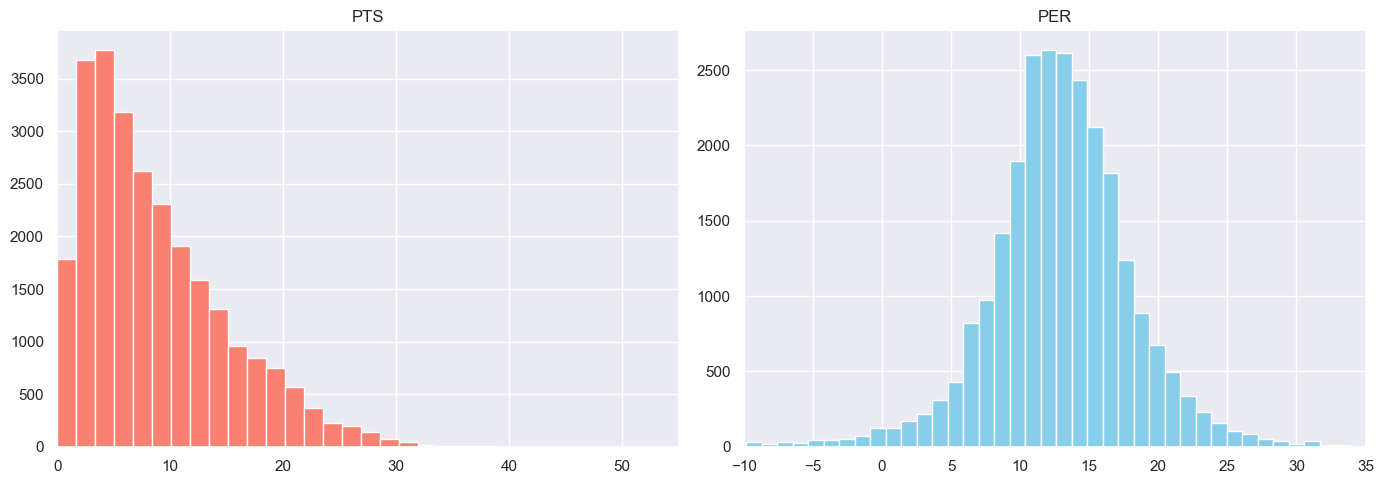

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5)) 

df['PTS'].hist(ax=axes[0], bins=30, color='salmon')
axes[0].set_title('PTS')
axes[0].set_xlim(0, 55)

df['PER'].hist(ax=axes[1], bins=200, color='skyblue')
axes[1].set_title('PER')
axes[1].set_xlim(-10, 35)

plt.tight_layout()
plt.show()

<Axes: >

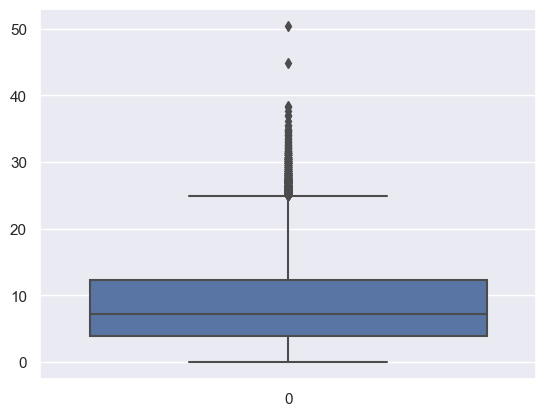

In [110]:
sns.boxplot(data=df['PTS'])

<Axes: xlabel='Pos', ylabel='3P'>

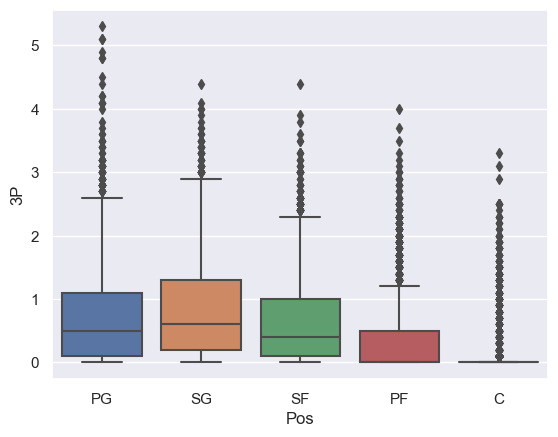

In [147]:
order = ['PG', 'SG', 'SF', 'PF', 'C']
sns.boxplot(x='Pos', y='3P', data=df[df['Season']>='1981/82'], order=order)

<h3>Dataset Preparation Function:</h3>
<p>1. Filtering the dataset to include only NBA players who played between 1981 and 2025
<p>2. Removing all rows corresponding to seasons in which a player played fewer than 500 minutes
<p>3. Excluding all players who played fewer than 6 seasons in the NBA
<p>4. Filling missing values in the <b>3P%</b> column with 0, for players who did not attempt any three-point shots during a season
<p>5. Scaling all percentage-based features to a range between 0 and 1, to ensure that all such attributes are on the same scale

In [8]:
def prepare_dataset(df):
    df = df[df['Season'] >= '1981-82']
    
    df = df[df["G"] * df["MP"] >= 500]
    
    min_6_seasons_player_ids = df.groupby("ID").filter(lambda x: len(x) >= 6)["ID"].unique()
    df = df[df["ID"].isin(min_6_seasons_player_ids)]

    df["3P%"] = df["3P%"].fillna(0)
    
    percentage_cols = ["ORB%", "DRB%", "TRB%", "AST%", "STL%", "BLK%", "TOV%", "USG%"]
    df[percentage_cols] = df[percentage_cols]/100
    
    return df

<h3>Function for Filtering Players Based on Career Timeline:</h3>
Only players who meet all three of the following criteria are included:

<p>1. Debuted in the NBA at age 25 or younger</p>

<p>2. Completed their first five seasons by the age of 29</p>

<p>3. Did not have a break longer than one year during those first five seasons</p>

In [9]:
def filter_young_debut_players(df, max_debut_age=25):
    debut_ids = df.groupby("ID").filter(
        lambda x: x.iloc[0]["Age"] <= max_debut_age and
                  x.iloc[4]["Age"] <= 29 and
                  x.iloc[4]["Age"] - x.iloc[0]["Age"] <= 5)["ID"].unique()
    
    return df[df["ID"].isin(debut_ids)]

<h3>Feature Engineering Function:</h3>
<p>1. Adding a feature that represents the number of seasons played by each player 
    
<p>2. Adding categorical features for each playing position – each feature returns 1 if the player played that position during the season, and 0 otherwise.

<p>3. Adding categorical features for individual awards – each feature returns 1 if the player received the respective award in that season, and 0 otherwise.

In [10]:
def feature_engineering(df):
    seasons_played = df.groupby('ID')['ID'].transform('count')
    seasons_played_df = pd.DataFrame({'Seasons_played': seasons_played})
    
    season_index = df.columns.get_loc('Season')
    df = pd.concat([df.iloc[:, :season_index], seasons_played_df, df.iloc[:, season_index:]], axis=1)
    
    positions_dummies = pd.get_dummies(df['Pos'], prefix='Pos')
    ordered_columns = ['Pos_PG', 'Pos_SG', 'Pos_SF', 'Pos_PF', 'Pos_C']
    positions_dummies = positions_dummies.reindex(columns=ordered_columns, fill_value=0)
    positions_dummies = positions_dummies.astype(int)
    pos_index = df.columns.get_loc('Pos')
    df = df.drop('Pos', axis=1)
    df = pd.concat([df.iloc[:, :pos_index], positions_dummies, df.iloc[:, pos_index:]], axis=1)

    df["MVP"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bMVP-1\b', x) else 0)
    df["AS"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bAS\b', x) else 0)
    df["NBA1"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bNBA1\b', x) else 0)
    df["NBA2"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bNBA2\b', x) else 0)
    df["NBA3"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bNBA3\b', x) else 0)
    df["ROY"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bROY-1\b', x) else 0)
    df["MIP"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bMIP-1\b', x) else 0)
    df["MVP_Top5"] = df["Awards"].apply(lambda x: 1 if pd.notna(x) and re.search(r'\bMVP-(2|3|4|5)\b', x) else 0)
    df.drop(columns=["Awards"], inplace=True)
    
    return df

<h3>Function for calculating:</h3> 
<p>1. the average values of a player's statistics during their first <b>n</b> NBA seasons
<p>2. the average values from the 6th to the 10th season, or up to the end of their career if they played fewer than 10 seasons in total

In [52]:
def calculate_average_stats(player, first_n_seasons, binary_pos_cols, binary_awards_cols, numeric_cols):
    
    starting_seasons = player.head(first_n_seasons)
    if len(player) < 10:
        next_seasons = player.iloc[5:]
    else:
        next_seasons = player.iloc[5:10]

    player_row = {
        'ID': player['ID'].iloc[0],
        'Player': player['Player'].iloc[0],
        'Seasons_played': player['Seasons_played'].iloc[0]
    }

    starting_pos_counts = starting_seasons[binary_pos_cols].sum()
    if not starting_pos_counts.empty:
        starting_pos_primary = starting_pos_counts.idxmax()
        for col in binary_pos_cols:
            player_row[f'{col}_1_{first_n_seasons}'] = 1 if col == starting_pos_primary else 0
    else:
        for col in binary_pos_cols:
            player_row[f'{col}_1_{first_n_seasons}'] = 0

    next_pos_counts = next_seasons[binary_pos_cols].sum()
    if not next_pos_counts.empty:
        next_pos_primary = next_pos_counts.idxmax()
        for col in binary_pos_cols:
            player_row[f'{col}_6_plus'] = 1 if col == next_pos_primary else 0
    else:
        for col in binary_pos_cols:
            player_row[f'{col}_6_plus'] = 0
    
    for col in numeric_cols:
        player_row[f'{col}_1_{first_n_seasons}'] = starting_seasons[col].mean()
        player_row[f'{col}_6_plus'] = next_seasons[col].mean()

    for col in binary_awards_cols:
        player_row[f'{col}_1_{first_n_seasons}'] = starting_seasons[col].sum()
        player_row[f'{col}_6_plus'] = next_seasons[col].sum()

    return pd.Series(player_row)

<h3>Function for assigning a class to each player

In [30]:
def assign_class(row):
    
    # Statistics for All-star:
    all_star_criteria = 0
    if row['MVP_6_plus'] >= 1: all_star_criteria += 2
    if row['NBA1_6_plus'] >= 1: all_star_criteria += 2
    if row['NBA2_6_plus'] >= 1: all_star_criteria += 1
    if row['NBA3_6_plus'] >= 1: all_star_criteria += 1
    if row['AS_6_plus'] >= 2: all_star_criteria += 1
    if row['AS_6_plus'] >= 3: all_star_criteria += 2   
    if row['MVP_Top5_6_plus'] >= 1: all_star_criteria += 1
    if row['PTS_6_plus'] >= 25: all_star_criteria += 1
    if row['PER_6_plus'] >= 21.5: all_star_criteria += 1
    if row['WS_6_plus'] >= 6.5: all_star_criteria += 1
    if row['Trp-Dbl_6_plus'] >= 20: all_star_criteria += 1

    if all_star_criteria >= 2:
        return 'all-star'
    
    # Statistics for Starter:
    starter_criteria = 0
    if row['AS_6_plus'] >= 1: starter_criteria += 1
    if row['PTS_6_plus'] >= 15: starter_criteria += 1
    if row['PER_6_plus'] >= 15: starter_criteria += 1
    if row['WS_6_plus'] >= 2: starter_criteria += 1
    if row['VORP_6_plus'] >= 1.5: starter_criteria += 1
    if row['Trp-Dbl_6_plus'] >= 3: starter_criteria += 1
    if row['MP_6_plus'] >= 28: starter_criteria += 1
    if row['GS_6_plus'] / row['G_6_plus'] >= 0.75: starter_criteria += 1
    
    if starter_criteria >= 2:
        return 'starter'
    
    return 'bench'

In [51]:
def calc_avg_stats_and_assign_class(df, first_n_seasons):
    
    binary_pos_cols = ['Pos_PG','Pos_SG','Pos_SF','Pos_PF','Pos_C']
    binary_awards_cols = ['Trp-Dbl','MVP','NBA1','NBA2','NBA3','AS','MIP','ROY','MVP_Top5']
    exclude_cols = ['ID', 'Player', 'Seasons_played', 'Season', 'Height', 'Weight', 'Age', 'Team', 'Lg'] + binary_pos_cols + binary_awards_cols
    numeric_cols = [col for col in df.columns if col not in exclude_cols]
     
    final_dataset = df.groupby('ID').apply(lambda player: calculate_average_stats(player, first_n_seasons, binary_pos_cols, binary_awards_cols, numeric_cols)).reset_index(drop=True)
    final_dataset = final_dataset.apply(lambda x: x.round(3) if x.dtype.kind == 'f' else x)

    fixed_cols = ['ID', 'Player', 'Seasons_played']

    first_n_seasons_cols = [col for col in final_dataset.columns if col.endswith(f'_1_{first_n_seasons}')]
    
    next_cols = [col for col in final_dataset.columns if col.endswith('_6_plus')]
    
    final_dataset = final_dataset[fixed_cols + first_n_seasons_cols + next_cols]

    final_dataset['Player_class'] = final_dataset.apply(lambda row: assign_class(row), axis=1)
    
    cols_to_drop = [col for col in df.columns if col.endswith('_6_plus')]
    df = df.drop(columns=cols_to_drop)
    
    return final_dataset

In [32]:
def remove_redundant_atts(df):
    cols_to_drop = [col for col in df.columns if col.endswith('_6_plus')]
    return df.drop(columns=cols_to_drop)

In [11]:
df = pd.read_csv("data/nba_player_stats.csv", low_memory=False)
df = prepare_dataset(df)
df = filter_young_debut_players(df)
df = feature_engineering(df)

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9702 entries, 35 to 26383
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              9702 non-null   int64  
 1   Player          9702 non-null   object 
 2   Height          9702 non-null   float64
 3   Weight          9702 non-null   float64
 4   Seasons_played  9702 non-null   int64  
 5   Season          9702 non-null   object 
 6   Age             9702 non-null   float64
 7   Team            9702 non-null   object 
 8   Lg              9702 non-null   object 
 9   Pos_PG          9702 non-null   int32  
 10  Pos_SG          9702 non-null   int32  
 11  Pos_SF          9702 non-null   int32  
 12  Pos_PF          9702 non-null   int32  
 13  Pos_C           9702 non-null   int32  
 14  G               9702 non-null   int64  
 15  GS              9702 non-null   float64
 16  MP              9702 non-null   float64
 17  FG              9702 non-null   floa

In [33]:
as_counts_with_0 = df.groupby('ID')['Awards'].apply(lambda x: x.fillna('').str.contains('AS').sum())
as_counts_with_0.value_counts(normalize=True)

Awards
0     0.900979
1     0.032003
2     0.017884
3     0.009789
4     0.008660
5     0.008095
6     0.005459
7     0.004518
8     0.002636
10    0.002071
12    0.001883
11    0.001506
9     0.001318
13    0.000941
14    0.000941
15    0.000565
19    0.000188
18    0.000188
16    0.000188
20    0.000188
Name: proportion, dtype: float64

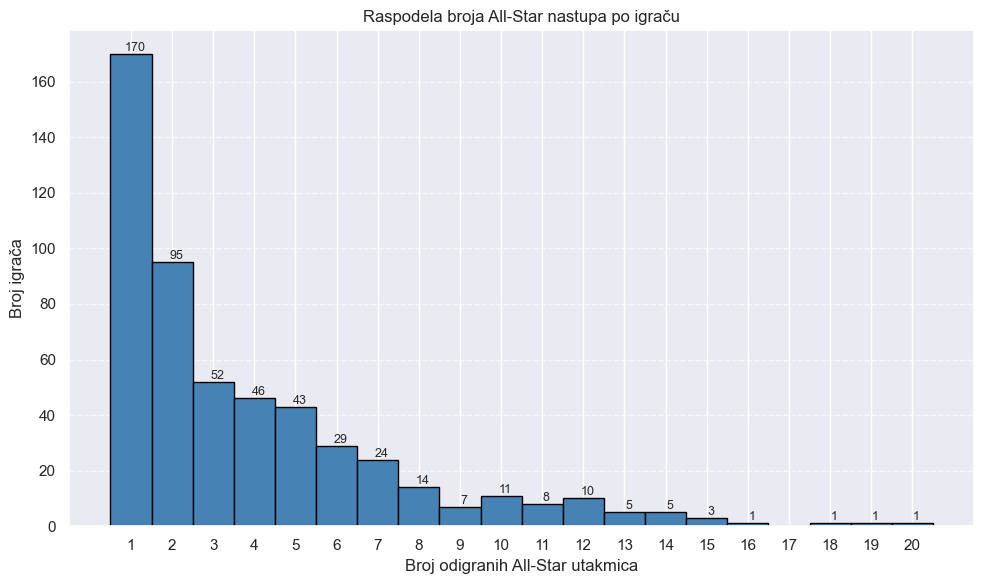

In [31]:
df = pd.read_csv("data/nba_player_stats.csv", low_memory=False)

as_counts = df.groupby('ID')['Awards'].apply(lambda x: x.fillna('').str.contains('AS').sum())
as_counts = as_counts[as_counts > 0]

plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(
    as_counts, 
    bins=range(as_counts.min(), as_counts.max() + 2), 
    edgecolor='black', 
    align='left', 
    color='steelblue'
)

for i in range(len(n)):
    if n[i] > 0:
        plt.text(bins[i] + 0.1, n[i], int(n[i]), ha='center', va='bottom', fontsize=9)

plt.xlabel('Broj odigranih All-Star utakmica')
plt.ylabel('Broj igrača')
plt.title('Raspodela broja All-Star nastupa po igraču')
plt.xticks(range(as_counts.min(), as_counts.max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
for n in [5, 3, 1]:
    final_df_with_plus_atts = calc_avg_stats_and_assign_class(df, n)
    final_df_with_plus_atts.to_csv(f"data/final_dataset_{n}_seasons_with_plus_atts.csv", index=False, encoding="utf-8-sig")
    final_df = remove_redundant_atts(final_df_with_plus_atts)
    final_df.to_csv(f"data/final_dataset_{n}_seasons.csv", index=False, encoding="utf-8-sig")

In [5]:
df_5 = pd.read_csv("data/final_dataset_5_seasons.csv", low_memory=False)
df_3 = pd.read_csv("data/final_dataset_3_seasons.csv", low_memory=False)
df_1 = pd.read_csv("data/final_dataset_1_seasons.csv", low_memory=False)

In [51]:
df_5["Player_class"].value_counts()

Player_class
bench       439
starter     375
all-star    128
Name: count, dtype: int64

<Axes: xlabel='Player_class', ylabel='PER_1_5'>

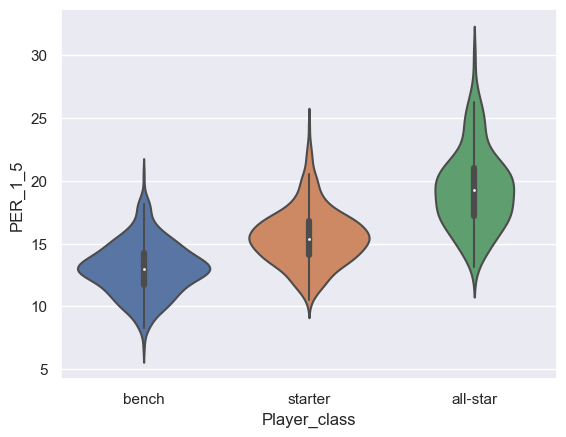

In [6]:
sns.violinplot(x='Player_class',y='PER_1_5', data=df_5)

In [249]:
df_5.head(5)

ID               Player  Seasons_played  Pos_PG_1_5  Pos_SG_1_5  \
0   4   Mahmoud Abdul-Rauf               8           1           0   
1   6  Shareef Abdur-Rahim              11           0           0   
2  23        Michael Adams               8           1           0   
3  24         Steven Adams              11           0           0   
4  26          Bam Adebayo               8           0           0   

   Pos_SF_1_5  Pos_PF_1_5  Pos_C_1_5  G_1_5  GS_1_5  MP_1_5  FG_1_5  FGA_1_5  \
0           0           0          0   76.4    46.4   27.24    6.46    14.54   
1           1           0          0   75.0    73.2   38.14    7.46    16.18   
2           0           0          0   73.4    58.4   32.08    5.44    13.12   
3           0           0          1   77.4    64.6   25.58    3.62     6.18   
4           0           0          1   68.6    47.8   28.56    5.28     9.46   

   FG%_1_5  3P_1_5  3PA_1_5  3P%_1_5  2P_1_5  2PA_1_5  2P%_1_5  eFG%_1_5  \
0    0.443    0.66     1.94    0.325    5.80    12.58    0.460     0.465   
1    0.461    0.22     0.72    0.293    7.24    15.42    0.470     0.468   
2    0.417    1.76     5.26    0.332    3.68     7.88    0.468     0.482   
3    0.572    0.00     0.00    0.000    3.62     6.16    0.573     0.572   
4    0.554    0.00     0.14    0.119    5.28     9.32    0.562     0.555   

   FT_1_5  FTA_1_5  FT%_1_5  ORB_1_5  DRB_1_5  TRB_1_5  AST_1_5  STL_1_5  \
0    1.96     2.14    0.901     0.42     1.54     2.00     3.56     0.88   
1    5.84     7.28    0.803     2.54     5.60     8.14     2.92     1.14   
2    3.66     4.30    0.846     0.70     2.30     3.02     6.64     1.84   
3    1.60     2.82    0.567     3.18     3.80     7.00     0.90     0.76   
4    3.32     4.46    0.740     2.14     6.24     8.42     3.52     1.02   

   BLK_1_5  TOV_1_5  PF_1_5  PTS_1_5  PER_1_5  TS%_1_5  3PAr_1_5  FTr_1_5  \
0     0.08     1.76    1.92    15.52    14.98    0.499     0.134    0.145   
1     1.02     3.10    2.72    20.96    19.70    0.541     0.045    0.448   
2     0.10     2.16    1.84    16.32    17.02    0.541     0.387    0.317   
3     1.00     1.38    2.74     8.84    15.58    0.586     0.002    0.501   
4     0.90     2.10    2.48    13.90    19.68    0.605     0.018    0.477   

   ORB%_1_5  DRB%_1_5  TRB%_1_5  AST%_1_5  STL%_1_5  BLK%_1_5  TOV%_1_5  \
0     0.017     0.063     0.039     0.216     0.016     0.002     0.104   
1     0.077     0.171     0.124     0.146     0.016     0.019     0.138   
2     0.022     0.077     0.048     0.266     0.026     0.002     0.128   
3     0.137     0.164     0.151     0.051     0.015     0.033     0.165   
4     0.088     0.238     0.164     0.188     0.017     0.030     0.155   

   USG%_1_5  OWS_1_5  DWS_1_5  WS_1_5  WS/48_1_5  OBPM_1_5  DBPM_1_5  BPM_1_5  \
0     0.260     2.06     1.28    3.30      0.064      0.30     -1.56    -1.24   
1     0.269     4.70     1.64    6.34      0.106      2.18     -1.02     1.16   
2     0.198     4.24     2.10    6.34      0.125      2.40      0.30     2.74   
3     0.143     3.40     2.50    5.94      0.139     -0.62      0.14    -0.48   
4     0.203     3.90     3.18    7.10      0.174      0.90      1.80     2.70   

   VORP_1_5  Trp-Dbl_1_5  MVP_1_5  NBA1_1_5  NBA2_1_5  NBA3_1_5  AS_1_5  \
0      0.68          0.0        0         0         0         0       0   
1      2.28          1.0        0         0         0         0       0   
2      2.88          1.0        0         0         0         0       0   
3      0.88          0.0        0         0         0         0       0   
4      2.42          5.0        0         0         0         0       1   

   MIP_1_5  ROY_1_5  MVP_Top5_1_5 Player_class  Player_class_num  
0        1        0             0        bench                 0  
1        0        0             0      starter                 1  
2        0        0             0      starter                 1  
3        0        0             0      starter                 1  


In [250]:
df_3.head(5)

ID               Player  Seasons_played  Pos_PG_1_3  Pos_SG_1_3  \
0   4   Mahmoud Abdul-Rauf               8           1           0   
1   6  Shareef Abdur-Rahim              11           0           0   
2  23        Michael Adams               8           1           0   
3  24         Steven Adams              11           0           0   
4  26          Bam Adebayo               8           0           0   

   Pos_SF_1_3  Pos_PF_1_3  Pos_C_1_3   G_1_3  GS_1_3  MP_1_3  FG_1_3  FGA_1_3  \
0           0           0          0  76.333  37.000  25.000   6.133   14.300   
1           1           0          0  70.667  67.667  37.133   7.533   16.500   
2           0           0          0  74.000  50.667  30.267   4.567   10.533   
3           0           0          1  77.000  55.667  21.767   2.500    4.433   
4           0           0          1  74.333  39.667  25.567   4.000    7.267   

   FG%_1_3  3P_1_3  3PA_1_3  3P%_1_3  2P_1_3  2PA_1_3  2P%_1_3  eFG%_1_3  \
0    0.428   0.567    1.700    0.308   5.633   12.600    0.443     0.447   
1    0.457   0.200    0.533    0.326   7.333   15.900    0.461     0.462   
2    0.430   1.433    4.100    0.333   3.133    6.433    0.483     0.492   
3    0.553   0.000    0.000    0.000   2.500    4.433    0.554     0.553   
4    0.548   0.000    0.167    0.114   4.000    7.100    0.558     0.550   

   FT_1_3  FTA_1_3  FT%_1_3  ORB_1_3  DRB_1_3  TRB_1_3  AST_1_3  STL_1_3  \
0   1.733    1.900    0.887    0.467    1.500    2.000    3.233    0.767   
1   6.100    7.700    0.790    2.600    4.567    7.167    2.733    1.167   
2   2.633    3.167    0.833    0.667    2.100    2.800    5.467    1.833   
3   1.300    2.367    0.555    2.433    3.600    6.100    0.733    0.500   
4   2.533    3.567    0.716    2.033    5.633    7.667    2.933    0.833   

   BLK_1_3  TOV_1_3  PF_1_3  PTS_1_3  PER_1_3  TS%_1_3  3PAr_1_3  FTr_1_3  \
0    0.067    1.767   2.000   14.533   13.467    0.477     0.117    0.130   
1    1.000    3.200   2.567   21.333   19.733    0.537     0.033    0.465   
2    0.133    1.800   1.667   13.200   15.800    0.544     0.367    0.298   
3    1.000    1.133   2.833    6.333   13.600    0.570     0.002    0.570   
4    0.900    1.767   2.333   10.567   17.967    0.597     0.023    0.492   

   ORB%_1_3  DRB%_1_3  TRB%_1_3  AST%_1_3  STL%_1_3  BLK%_1_3  TOV%_1_3  \
0     0.018     0.065     0.041     0.203     0.015     0.002     0.107   
1     0.081     0.145     0.112     0.144     0.016     0.020     0.139   
2     0.023     0.075     0.048     0.235     0.029     0.003     0.134   
3     0.129     0.175     0.153     0.049     0.013     0.037     0.178   
4     0.091     0.235     0.164     0.165     0.016     0.031     0.161   

   USG%_1_3  OWS_1_3  DWS_1_3  WS_1_3  WS/48_1_3  OBPM_1_3  DBPM_1_3  BPM_1_3  \
0     0.265    0.700    0.900   1.567      0.026    -0.767    -2.000   -2.733   
1     0.283    3.900    0.900   4.800      0.090     2.200    -1.600    0.600   
2     0.174    3.667    2.533   6.167      0.124     1.400     0.767    2.200   
3     0.129    2.333    2.133   4.500      0.127    -1.533     0.433   -1.100   
4     0.176    3.433    3.067   6.500      0.162    -0.033     1.633    1.600   

   VORP_1_3  Trp-Dbl_1_3  MVP_1_3  NBA1_1_3  NBA2_1_3  NBA3_1_3  AS_1_3  \
0    -0.067          0.0        0         0         0         0       0   
1     1.633          1.0        0         0         0         0       0   
2     2.500          0.0        0         0         0         0       0   
3     0.433          0.0        0         0         0         0       0   
4     1.900          3.0        0         0         0         0       1   

   MIP_1_3  ROY_1_3  MVP_Top5_1_3 Player_class  Player_class_num  
0        1        0             0        bench                 0  
1        0        0             0      starter                 1  
2        0        0             0      starter                 1  
3        0        0             0      starter               

In [251]:
df_1.head(5)

ID               Player  Seasons_played  Pos_PG_1_1  Pos_SG_1_1  \
0   4   Mahmoud Abdul-Rauf               8           1           0   
1   6  Shareef Abdur-Rahim              11           0           0   
2  23        Michael Adams               8           1           0   
3  24         Steven Adams              11           0           0   
4  26          Bam Adebayo               8           0           0   

   Pos_SF_1_1  Pos_PF_1_1  Pos_C_1_1  G_1_1  GS_1_1  MP_1_1  FG_1_1  FGA_1_1  \
0           0           0          0   67.0    19.0    22.5     6.2     15.1   
1           0           1          0   80.0    71.0    35.0     6.9     15.2   
2           0           0          0   63.0     0.0    20.7     2.5      6.2   
3           0           0          1   81.0    20.0    14.8     1.1      2.3   
4           0           0          1   69.0    19.0    19.8     2.5      4.9   

   FG%_1_1  3P_1_1  3PA_1_1  3P%_1_1  2P_1_1  2PA_1_1  2P%_1_1  eFG%_1_1  \
0    0.413     0.4      1.5    0.240     5.9     13.6    0.432     0.425   
1    0.453     0.1      0.3    0.259     6.8     14.8    0.457     0.456   
2    0.407     0.4      1.6    0.275     2.1      4.6    0.454     0.443   
3    0.503     0.0      0.0    0.000     1.1      2.3    0.503     0.503   
4    0.512     0.0      0.1    0.000     2.5      4.8    0.523     0.512   

   FT_1_1  FTA_1_1  FT%_1_1  ORB_1_1  DRB_1_1  TRB_1_1  AST_1_1  STL_1_1  \
0     1.3      1.5    0.857      0.5      1.3      1.8      3.1      0.8   
1     4.8      6.5    0.746      2.7      4.2      6.9      2.2      1.0   
2     1.7      2.0    0.847      0.6      1.3      2.0      3.9      1.3   
3     1.0      1.7    0.581      1.8      2.3      4.1      0.5      0.5   
4     1.9      2.6    0.721      1.7      3.8      5.5      1.5      0.5   

   BLK_1_1  TOV_1_1  PF_1_1  PTS_1_1  PER_1_1  TS%_1_1  3PAr_1_1  FTr_1_1  \
0      0.1      1.6     2.2     14.1     12.2    0.448     0.099    0.097   
1      1.0      2.8     2.5     18.7     17.4    0.518     0.022    0.428   
2      0.1      1.3     1.4      7.2     14.3    0.506     0.260    0.316   
3      0.7      0.9     2.5      3.3     11.2    0.541     0.000    0.735   
4      0.6      1.0     2.0      6.9     15.7    0.570     0.021    0.526   

   ORB%_1_1  DRB%_1_1  TRB%_1_1  AST%_1_1  STL%_1_1  BLK%_1_1  TOV%_1_1  \
0     0.019     0.060     0.038     0.192     0.015     0.001     0.095   
1     0.088     0.142     0.115     0.121     0.015     0.022     0.135   
2     0.030     0.070     0.050     0.257     0.031     0.003     0.153   
3     0.141     0.171     0.156     0.049     0.017     0.039     0.225   
4     0.097     0.216     0.156     0.110     0.012     0.025     0.136   

   USG%_1_1  OWS_1_1  DWS_1_1  WS_1_1  WS/48_1_1  OBPM_1_1  DBPM_1_1  BPM_1_1  \
0     0.272     -0.7     -0.3    -1.0     -0.031      -2.0      -3.0     -5.0   
1     0.276      1.7      1.2     2.9      0.049       0.3      -2.1     -1.8   
2     0.163      1.2      1.5     2.7      0.099       0.0       1.2      1.2   
3     0.117      0.9      1.9     2.9      0.114      -3.1       0.9     -2.2   
4     0.159      2.3      1.9     4.2      0.148      -1.1       0.7     -0.4   

   VORP_1_1  Trp-Dbl_1_1  MVP_1_1  NBA1_1_1  NBA2_1_1  NBA3_1_1  AS_1_1  \
0      -1.1          0.0        0         0         0         0       0   
1       0.2          1.0        0         0         0         0       0   
2       1.0          0.0        0         0         0         0       0   
3      -0.1          0.0        0         0         0         0       0   
4       0.6          0.0        0         0         0         0       0   

   MIP_1_1  ROY_1_1  MVP_Top5_1_1 Player_class  Player_class_num  
0        0        0             0        bench                 0  
1        0        0             0      starter                 1  
2        0        0             0      starter                 1  
3        0        0             0      starter                 1  


In [52]:
df_5.describe()

ID  Seasons_played  Pos_PG_1_5  Pos_SG_1_5  Pos_SF_1_5  \
count   942.000000      942.000000  942.000000  942.000000  942.000000   
mean   2613.505308       10.299363    0.211253    0.208068    0.197452   
std    1556.203495        3.279664    0.408414    0.406141    0.398288   
min       4.000000        6.000000    0.000000    0.000000    0.000000   
25%    1238.500000        8.000000    0.000000    0.000000    0.000000   
50%    2612.500000       10.000000    0.000000    0.000000    0.000000   
75%    3932.000000       12.000000    0.000000    0.000000    0.000000   
max    5312.000000       22.000000    1.000000    1.000000    1.000000   

       Pos_PF_1_5   Pos_C_1_5      G_1_5      GS_1_5      MP_1_5      FG_1_5  \
count  942.000000  942.000000  942.00000  942.000000  942.000000  942.000000   
mean     0.195329    0.187898   69.62293   40.504459   26.302081    4.376136   
std      0.396664    0.390838    7.01133   21.147790    6.116150    1.790499   
min      0.000000    0.000000   44.20000    1.400000   11.820000    0.940000   
25%      0.000000    0.000000   65.00000   21.250000   21.305000    3.000000   
50%      0.000000    0.000000   70.10000   41.000000   26.380000    4.160000   
75%      0.000000    0.000000   74.80000   58.150000   31.120000    5.575000   
max      1.000000    1.000000   82.20000   81.800000   41.140000   12.220000   

          FGA_1_5     FG%_1_5      3P_1_5     3PA_1_5     3P%_1_5      2P_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     9.404650    0.465209    0.602144    1.710722    0.244994    3.772866   
std      3.739556    0.046256    0.655195    1.745128    0.131972    1.780557   
min      2.120000    0.366000    0.000000    0.000000    0.000000    0.720000   
25%      6.485000    0.432000    0.000000    0.120000    0.142500    2.400000   
50%      8.920000    0.459000    0.400000    1.230000    0.296500    3.480000   
75%     12.010000    0.491000    1.000000    2.840000    0.352000    4.875000   
max     23.640000    0.707000    3.040000    8.260000    0.467000   11.880000   

          2PA_1_5     2P%_1_5    eFG%_1_5      FT_1_5     FTA_1_5     FT%_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     7.691996    0.487947    0.496464    2.202272    2.929257    0.744358   
std      3.508014    0.042372    0.038022    1.267611    1.617287    0.083034   
min      1.480000    0.383000    0.385000    0.360000    0.440000    0.384000   
25%      4.900000    0.461000    0.472000    1.300000    1.745000    0.704250   
50%      7.010000    0.483000    0.493000    1.920000    2.580000    0.755000   
75%      9.880000    0.510000    0.518000    2.800000    3.755000    0.803000   
max     22.380000    0.707000    0.707000    8.440000    9.960000    0.901000   

          ORB_1_5     DRB_1_5     TRB_1_5     AST_1_5     STL_1_5     BLK_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.364225    3.307304    4.670340    2.534607    0.901868    0.577834   
std      0.858436    1.544525    2.287445    1.860788    0.420000    0.557896   
min      0.180000    0.800000    1.060000    0.280000    0.200000    0.000000   
25%      0.645000    2.180000    2.940000    1.180000    0.600000    0.220000   
50%      1.180000    2.990000    4.190000    2.000000    0.820000    0.380000   
75%      1.940000    4.100000    5.920000    3.395000    1.120000    0.735000   
max      4.640000    8.940000   12.580000   11.660000    2.900000    3.800000   

          TOV_1_5      PF_1_5     PTS_1_5     PER_1_5     TS%_1_5    3PAr_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.657431    2.372590   11.557962   14.878238    0.536797    0.178253   
std      0.706159    0.592785    4.822134    3.148023    0.035240    0.174623   
min      0.400000    0.920000    2.260000    6.800000    0.417000    0.000000   
25%      1.100000    1.960000    

In [53]:
df_3.describe()

ID  Seasons_played  Pos_PG_1_3  Pos_SG_1_3  Pos_SF_1_3  \
count   942.000000      942.000000  942.000000  942.000000  942.000000   
mean   2613.505308       10.299363    0.211253    0.215499    0.191083   
std    1556.203495        3.279664    0.408414    0.411386    0.393363   
min       4.000000        6.000000    0.000000    0.000000    0.000000   
25%    1238.500000        8.000000    0.000000    0.000000    0.000000   
50%    2612.500000       10.000000    0.000000    0.000000    0.000000   
75%    3932.000000       12.000000    0.000000    0.000000    0.000000   
max    5312.000000       22.000000    1.000000    1.000000    1.000000   

       Pos_PF_1_3   Pos_C_1_3       G_1_3      GS_1_3      MP_1_3      FG_1_3  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     0.199575    0.182590   70.112167   37.488327   25.098271    4.089632   
std      0.399893    0.386535    8.415285   23.286105    6.588571    1.781640   
min      0.000000    0.000000   41.000000    0.000000   10.967000    0.867000   
25%      0.000000    0.000000   64.667000   16.000000   19.775250    2.741500   
50%      0.000000    0.000000   71.333000   36.000000   25.000000    3.733000   
75%      0.000000    0.000000   77.000000   57.000000   29.967000    5.167000   
max      1.000000    1.000000   82.333000   82.000000   41.467000   12.200000   

          FGA_1_3     FG%_1_3      3P_1_3     3PA_1_3     3P%_1_3      2P_1_3  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     8.811432    0.463850    0.513479    1.479753    0.238550    3.574701   
std      3.730772    0.047986    0.600641    1.612255    0.135654    1.777393   
min      2.133000    0.358000    0.000000    0.000000    0.000000    0.533000   
25%      5.975250    0.430000    0.000000    0.067000    0.138250    2.233000   
50%      8.033000    0.458000    0.233000    0.867000    0.289500    3.167000   
75%     11.091750    0.492000    0.900000    2.500000    0.348000    4.533000   
max     24.000000    0.696000    3.367000    8.233000    0.489000   12.100000   

          2PA_1_3     2P%_1_3    eFG%_1_3      FT_1_3     FTA_1_3     FT%_1_3  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     7.329787    0.485104    0.492486    2.042162    2.751170    0.737110   
std      3.529264    0.043732    0.039947    1.187952    1.539954    0.083843   
min      1.267000    0.375000    0.385000    0.267000    0.333000    0.393000   
25%      4.675250    0.457000    0.466000    1.200000    1.633000    0.692000   
50%      6.600000    0.481000    0.489000    1.750000    2.433000    0.750500   
75%      9.300000    0.508000    0.514000    2.533000    3.433000    0.796000   
max     23.300000    0.696000    0.696000    8.900000   10.500000    0.892000   

          ORB_1_3     DRB_1_3     TRB_1_3     AST_1_3     STL_1_3     BLK_1_3  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.343456    3.120456    4.462676    2.355807    0.867056    0.566760   
std      0.846590    1.503035    2.236585    1.802822    0.424148    0.556357   
min      0.167000    0.700000    0.967000    0.100000    0.167000    0.000000   
25%      0.633000    2.041500    2.800000    1.100000    0.567000    0.200000   
50%      1.200000    2.800000    3.967000    1.767000    0.800000    0.367000   
75%      1.867000    3.867000    5.600000    3.100000    1.067000    0.733000   
max      4.833000    8.633000   12.833000   11.033000    2.833000    4.100000   

          TOV_1_3      PF_1_3     PTS_1_3     PER_1_3     TS%_1_3    3PAr_1_3  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.604702    2.352044   10.734926   14.457966    0.532572    0.165741   
std      0.729595    0.628961    4.705428    3.019820    0.036967    0.172110   
min      0.400000    0.767000    2.033000    6.533000    0.413000    0.000000   
25%      1.067000    1.9

In [54]:
df_1.describe()

ID  Seasons_played  Pos_PG_1_1  Pos_SG_1_1  Pos_SF_1_1  \
count   942.000000      942.000000  942.000000  942.000000  942.000000   
mean   2613.505308       10.299363    0.215499    0.207006    0.196391   
std    1556.203495        3.279664    0.411386    0.405375    0.397478   
min       4.000000        6.000000    0.000000    0.000000    0.000000   
25%    1238.500000        8.000000    0.000000    0.000000    0.000000   
50%    2612.500000       10.000000    0.000000    0.000000    0.000000   
75%    3932.000000       12.000000    0.000000    0.000000    0.000000   
max    5312.000000       22.000000    1.000000    1.000000    1.000000   

       Pos_PF_1_1   Pos_C_1_1       G_1_1      GS_1_1      MP_1_1      FG_1_1  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     0.203822    0.177282   69.188960   29.458599   22.089809    3.423885   
std      0.403052    0.382110   12.781261   27.418121    7.532975    1.740605   
min      0.000000    0.000000   25.000000    0.000000    7.900000    0.600000   
25%      0.000000    0.000000   61.250000    4.000000   16.000000    2.100000   
50%      0.000000    0.000000   73.000000   20.000000   21.400000    3.100000   
75%      0.000000    0.000000   80.000000   53.000000   27.700000    4.300000   
max      1.000000    1.000000   83.000000   82.000000   40.900000   10.200000   

          FGA_1_1     FG%_1_1      3P_1_1     3PA_1_1     3P%_1_1      2P_1_1  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     7.488854    0.458207    0.395117    1.169002    0.226824    3.028132   
std      3.710446    0.054209    0.527800    1.424797    0.165729    1.714291   
min      1.500000    0.303000    0.000000    0.000000    0.000000    0.500000   
25%      4.600000    0.422000    0.000000    0.100000    0.000000    1.800000   
50%      6.700000    0.453000    0.100000    0.500000    0.273500    2.600000   
75%      9.500000    0.490000    0.700000    1.975000    0.341750    3.900000   
max     19.800000    0.701000    3.700000    8.300000    1.000000   10.100000   

          2PA_1_1     2P%_1_1    eFG%_1_1      FT_1_1     FTA_1_1     FT%_1_1  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     6.316242    0.477689    0.484304    1.673567    2.308917    0.722453   
std      3.464246    0.051192    0.047987    1.075716    1.431186    0.093585   
min      0.900000    0.265000    0.345000    0.100000    0.100000    0.306000   
25%      3.725000    0.446000    0.452000    0.900000    1.300000    0.670000   
50%      5.400000    0.474500    0.480500    1.400000    2.000000    0.732000   
75%      8.100000    0.504000    0.511000    2.100000    2.900000    0.791000   
max     19.200000    0.701000    0.701000    7.700000   10.200000    0.931000   

          ORB_1_1     DRB_1_1     TRB_1_1     AST_1_1     STL_1_1     BLK_1_1  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.248620    2.693949    3.943631    1.979618    0.772081    0.518896   
std      0.837329    1.470242    2.190535    1.691225    0.433844    0.547454   
min      0.100000    0.400000    0.700000    0.100000    0.100000    0.000000   
25%      0.600000    1.700000    2.325000    0.800000    0.500000    0.200000   
50%      1.100000    2.400000    3.500000    1.500000    0.700000    0.300000   
75%      1.700000    3.300000    5.000000    2.500000    1.000000    0.700000   
max      5.400000    9.600000   13.900000   10.600000    2.700000    5.000000   

          TOV_1_1      PF_1_1     PTS_1_1     PER_1_1     TS%_1_1    3PAr_1_1  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.444692    2.227070    8.916773   13.504034    0.523113    0.154525   
std      0.772267    0.725269    4.516776    3.092393    0.044145    0.171476   
min      0.200000    0.500000    1.500000    4.900000    0.356000    0.000000   
25%      0.900000    1.7

In [4]:
df_5.describe(include=object)

Player Player_class
count                  942          942
unique                 942            3
top     Mahmoud Abdul-Rauf        bench
freq                     1          439

In [14]:
df_5.describe(exclude=object)

ID  Seasons_played  Pos_PG_1_5  Pos_SG_1_5  Pos_SF_1_5  \
count   942.000000      942.000000  942.000000  942.000000  942.000000   
mean   2613.505308       10.299363    0.211253    0.208068    0.197452   
std    1556.203495        3.279664    0.408414    0.406141    0.398288   
min       4.000000        6.000000    0.000000    0.000000    0.000000   
25%    1238.500000        8.000000    0.000000    0.000000    0.000000   
50%    2612.500000       10.000000    0.000000    0.000000    0.000000   
75%    3932.000000       12.000000    0.000000    0.000000    0.000000   
max    5312.000000       22.000000    1.000000    1.000000    1.000000   

       Pos_PF_1_5   Pos_C_1_5      G_1_5      GS_1_5      MP_1_5      FG_1_5  \
count  942.000000  942.000000  942.00000  942.000000  942.000000  942.000000   
mean     0.195329    0.187898   69.62293   40.504459   26.302081    4.376136   
std      0.396664    0.390838    7.01133   21.147790    6.116150    1.790499   
min      0.000000    0.000000   44.20000    1.400000   11.820000    0.940000   
25%      0.000000    0.000000   65.00000   21.250000   21.305000    3.000000   
50%      0.000000    0.000000   70.10000   41.000000   26.380000    4.160000   
75%      0.000000    0.000000   74.80000   58.150000   31.120000    5.575000   
max      1.000000    1.000000   82.20000   81.800000   41.140000   12.220000   

          FGA_1_5     FG%_1_5      3P_1_5     3PA_1_5     3P%_1_5      2P_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     9.404650    0.465209    0.602144    1.710722    0.244994    3.772866   
std      3.739556    0.046256    0.655195    1.745128    0.131972    1.780557   
min      2.120000    0.366000    0.000000    0.000000    0.000000    0.720000   
25%      6.485000    0.432000    0.000000    0.120000    0.142500    2.400000   
50%      8.920000    0.459000    0.400000    1.230000    0.296500    3.480000   
75%     12.010000    0.491000    1.000000    2.840000    0.352000    4.875000   
max     23.640000    0.707000    3.040000    8.260000    0.467000   11.880000   

          2PA_1_5     2P%_1_5    eFG%_1_5      FT_1_5     FTA_1_5     FT%_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     7.691996    0.487947    0.496464    2.202272    2.929257    0.744358   
std      3.508014    0.042372    0.038022    1.267611    1.617287    0.083034   
min      1.480000    0.383000    0.385000    0.360000    0.440000    0.384000   
25%      4.900000    0.461000    0.472000    1.300000    1.745000    0.704250   
50%      7.010000    0.483000    0.493000    1.920000    2.580000    0.755000   
75%      9.880000    0.510000    0.518000    2.800000    3.755000    0.803000   
max     22.380000    0.707000    0.707000    8.440000    9.960000    0.901000   

          ORB_1_5     DRB_1_5     TRB_1_5     AST_1_5     STL_1_5     BLK_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.364225    3.307304    4.670340    2.534607    0.901868    0.577834   
std      0.858436    1.544525    2.287445    1.860788    0.420000    0.557896   
min      0.180000    0.800000    1.060000    0.280000    0.200000    0.000000   
25%      0.645000    2.180000    2.940000    1.180000    0.600000    0.220000   
50%      1.180000    2.990000    4.190000    2.000000    0.820000    0.380000   
75%      1.940000    4.100000    5.920000    3.395000    1.120000    0.735000   
max      4.640000    8.940000   12.580000   11.660000    2.900000    3.800000   

          TOV_1_5      PF_1_5     PTS_1_5     PER_1_5     TS%_1_5    3PAr_1_5  \
count  942.000000  942.000000  942.000000  942.000000  942.000000  942.000000   
mean     1.657431    2.372590   11.557962   14.878238    0.536797    0.178253   
std      0.706159    0.592785    4.822134    3.148023    0.035240    0.174623   
min      0.400000    0.920000    2.260000    6.800000    0.417000    0.000000   
25%      1.100000    1.960000    

In [20]:
df_5[df_5['Player_class'] == 'bench'].describe(exclude=object)

ID  Seasons_played  Pos_PG_1_5  Pos_SG_1_5  Pos_SF_1_5  \
count   439.000000      439.000000  439.000000  439.000000  439.000000   
mean   2631.676538        8.630979    0.214123    0.227790    0.205011   
std    1559.275793        2.156131    0.410681    0.419885    0.404171   
min       4.000000        6.000000    0.000000    0.000000    0.000000   
25%    1200.000000        7.000000    0.000000    0.000000    0.000000   
50%    2638.000000        8.000000    0.000000    0.000000    0.000000   
75%    3954.500000       10.000000    0.000000    0.000000    0.000000   
max    5286.000000       17.000000    1.000000    1.000000    1.000000   

       Pos_PF_1_5   Pos_C_1_5       G_1_5      GS_1_5      MP_1_5      FG_1_5  \
count  439.000000  439.000000  439.000000  439.000000  439.000000  439.000000   
mean     0.189066    0.164009   68.343964   30.672437   23.180547    3.475672   
std      0.392008    0.370706    6.922906   18.218199    5.072684    1.376916   
min      0.000000    0.000000   44.200000    1.400000   11.820000    0.940000   
25%      0.000000    0.000000   64.000000   14.600000   19.510000    2.510000   
50%      0.000000    0.000000   69.000000   29.800000   22.720000    3.220000   
75%      0.000000    0.000000   73.400000   44.700000   26.580000    4.220000   
max      1.000000    1.000000   81.800000   78.800000   37.820000    8.840000   

          FGA_1_5     FG%_1_5      3P_1_5     3PA_1_5     3P%_1_5      2P_1_5  \
count  439.000000  439.000000  439.000000  439.000000  439.000000  439.000000   
mean     7.657677    0.453686    0.532802    1.504465    0.240103    2.940091   
std      2.927462    0.039865    0.597739    1.557936    0.135956    1.421908   
min      2.120000    0.375000    0.000000    0.000000    0.000000    0.720000   
25%      5.540000    0.423000    0.000000    0.080000    0.126000    1.960000   
50%      7.080000    0.449000    0.360000    1.100000    0.288000    2.620000   
75%      9.290000    0.480000    0.900000    2.530000    0.352000    3.620000   
max     18.540000    0.606000    3.040000    7.480000    0.467000    8.600000   

          2PA_1_5     2P%_1_5    eFG%_1_5      FT_1_5     FTA_1_5     FT%_1_5  \
count  439.000000  439.000000  439.000000  439.000000  439.000000  439.000000   
mean     6.150433    0.476185    0.487656    1.583964    2.130615    0.738164   
std      2.894554    0.037409    0.034965    0.825885    1.053408    0.086851   
min      1.480000    0.385000    0.385000    0.360000    0.440000    0.419000   
25%      4.020000    0.448000    0.465500    1.010000    1.380000    0.695500   
50%      5.580000    0.476000    0.484000    1.420000    1.940000    0.753000   
75%      7.580000    0.497000    0.508000    2.000000    2.650000    0.799500   
max     17.720000    0.628000    0.606000    6.440000    7.680000    0.901000   

          ORB_1_5     DRB_1_5     TRB_1_5     AST_1_5     STL_1_5     BLK_1_5  \
count  439.000000  439.000000  439.000000  439.000000  439.000000  439.000000   
mean     1.125330    2.672984    3.796583    2.042187    0.773303    0.443781   
std      0.691826    1.110635    1.699427    1.466192    0.335734    0.427134   
min      0.180000    0.800000    1.060000    0.280000    0.200000    0.000000   
25%      0.560000    1.860000    2.500000    0.980000    0.520000    0.160000   
50%      0.960000    2.480000    3.420000    1.640000    0.720000    0.320000   
75%      1.640000    3.290000    4.930000    2.630000    0.940000    0.560000   
max      4.400000    7.280000   10.380000    9.600000    2.400000    3.780000   

          TOV_1_5      PF_1_5     PTS_1_5     PER_1_5     TS%_1_5    3PAr_1_5  \
count  439.000000  439.000000  439.000000  439.000000  439.000000  439.000000   
mean     1.352756    2.231845    9.069157   13.022187    0.525267    0.192722   
std      0.553418    0.574178    3.506805    2.104391    0.032245    0.190233   
min      0.400000    0.920000    2.260000    6.800000    0.417000    0.000000   
25%      0.960000    1.8

In [21]:
df_5[df_5['Player_class'] == 'starter'].describe(exclude=object)

ID  Seasons_played  Pos_PG_1_5  Pos_SG_1_5  Pos_SF_1_5  \
count   375.000000      375.000000  375.000000  375.000000  375.000000   
mean   2607.632000       11.010667    0.194667    0.197333    0.192000   
std    1573.473646        3.059987    0.396473    0.398518    0.394399   
min       6.000000        6.000000    0.000000    0.000000    0.000000   
25%    1343.500000        8.000000    0.000000    0.000000    0.000000   
50%    2590.000000       11.000000    0.000000    0.000000    0.000000   
75%    3941.000000       13.000000    0.000000    0.000000    0.000000   
max    5312.000000       19.000000    1.000000    1.000000    1.000000   

       Pos_PF_1_5   Pos_C_1_5       G_1_5      GS_1_5      MP_1_5      FG_1_5  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.000000   
mean     0.202667    0.213333   70.086400   45.026133   27.697920    4.677280   
std      0.402523    0.410208    7.049588   19.528870    5.496704    1.445586   
min      0.000000    0.000000   45.000000    1.600000   13.020000    1.580000   
25%      0.000000    0.000000   65.400000   30.000000   23.870000    3.570000   
50%      0.000000    0.000000   70.800000   47.000000   28.020000    4.600000   
75%      0.000000    0.000000   75.600000   62.000000   31.790000    5.690000   
max      1.000000    1.000000   82.200000   81.800000   40.020000    9.620000   

          FGA_1_5     FG%_1_5      3P_1_5     3PA_1_5     3P%_1_5      2P_1_5  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.000000   
mean    10.012533    0.471781    0.647360    1.850720    0.247493    4.030133   
std      3.236690    0.050516    0.674981    1.835568    0.130788    1.442882   
min      3.840000    0.366000    0.000000    0.000000    0.000000    1.080000   
25%      7.610000    0.436500    0.020000    0.120000    0.146500    2.860000   
50%      9.840000    0.463000    0.440000    1.340000    0.304000    3.940000   
75%     12.490000    0.497000    1.080000    3.010000    0.349000    4.950000   
max     18.880000    0.707000    2.580000    7.220000    0.430000    9.500000   

          2PA_1_5     2P%_1_5    eFG%_1_5      FT_1_5     FTA_1_5     FT%_1_5  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.000000   
mean     8.159627    0.495808    0.502032    2.354347    3.138720    0.745432   
std      2.933496    0.045527    0.040519    1.028321    1.292389    0.076863   
min      2.380000    0.383000    0.402000    0.500000    0.640000    0.384000   
25%      5.860000    0.468000    0.478000    1.600000    2.200000    0.704500   
50%      8.000000    0.487000    0.497000    2.200000    2.920000    0.754000   
75%     10.040000    0.515500    0.521500    2.940000    3.950000    0.799500   
max     17.180000    0.707000    0.707000    6.860000    7.840000    0.886000   

          ORB_1_5     DRB_1_5     TRB_1_5     AST_1_5     STL_1_5    BLK_1_5  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.00000   
mean     1.484373    3.565387    5.050240    2.640747    0.938613    0.63920   
std      0.868519    1.414638    2.172213    1.823015    0.404872    0.55361   
min      0.180000    0.980000    1.280000    0.280000    0.260000    0.04000   
25%      0.720000    2.440000    3.380000    1.280000    0.650000    0.26000   
50%      1.360000    3.260000    4.700000    2.120000    0.880000    0.46000   
75%      2.100000    4.390000    6.390000    3.500000    1.160000    0.88000   
max      4.540000    8.380000   12.580000    9.340000    2.900000    3.32000   

          TOV_1_5      PF_1_5     PTS_1_5     PER_1_5     TS%_1_5    3PAr_1_5  \
count  375.000000  375.000000  375.000000  375.000000  375.000000  375.000000   
mean     1.751307    2.433120   12.359147   15.524107    0.542829    0.173899   
std      0.642237    0.576948    3.890289    2.250225    0.035195    0.165569   
min      0.600000    0.960000    4.600000   10.480000    0.462000    0.000000   
25%      1.260000    2.020000    

In [22]:
df_5[df_5['Player_class'] == 'all-star'].describe(exclude=object)

ID  Seasons_played  Pos_PG_1_5  Pos_SG_1_5  Pos_SF_1_5  \
count   128.000000      128.000000  128.000000  128.000000  128.000000   
mean   2568.390625       13.937500    0.250000    0.171875    0.187500   
std    1504.802633        3.410844    0.434714    0.378754    0.391846   
min      26.000000        7.000000    0.000000    0.000000    0.000000   
25%    1255.750000       12.000000    0.000000    0.000000    0.000000   
50%    2545.500000       14.000000    0.000000    0.000000    0.000000   
75%    3754.500000       16.000000    0.250000    0.000000    0.000000   
max    5247.000000       22.000000    1.000000    1.000000    1.000000   

       Pos_PF_1_5   Pos_C_1_5       G_1_5      GS_1_5      MP_1_5      FG_1_5  \
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean     0.195312    0.195312   72.651562   60.978125   32.918594    6.582187   
std      0.397999    0.397999    6.088080   15.130846    3.985991    1.756619   
min      0.000000    0.000000   52.000000   10.400000   21.600000    2.360000   
25%      0.000000    0.000000   69.000000   53.350000   30.725000    5.455000   
50%      0.000000    0.000000   73.000000   65.500000   33.400000    6.570000   
75%      0.000000    0.000000   77.850000   72.050000   36.210000    7.570000   
max      1.000000    1.000000   82.000000   81.800000   41.140000   12.220000   

          FGA_1_5     FG%_1_5      3P_1_5     3PA_1_5     3P%_1_5      2P_1_5  \
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean    13.615312    0.485477    0.707500    2.007969    0.254445    5.875312   
std      3.701123    0.043093    0.756944    1.994549    0.121385    1.827331   
min      4.280000    0.399000    0.000000    0.000000    0.000000    2.220000   
25%     11.365000    0.452750    0.020000    0.180000    0.164750    4.495000   
50%     13.540000    0.482500    0.450000    1.370000    0.289500    5.790000   
75%     16.435000    0.515250    1.270000    3.480000    0.356500    7.050000   
max     23.640000    0.640000    2.840000    8.260000    0.442000   11.880000   

          2PA_1_5     2P%_1_5    eFG%_1_5      FT_1_5     FTA_1_5     FT%_1_5  \
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean    11.609063    0.505258    0.510359    3.877344    5.054688    0.762453   
std      3.552432    0.037551    0.033259    1.490500    1.935748    0.084893   
min      4.280000    0.429000    0.448000    0.880000    1.660000    0.389000   
25%      8.965000    0.478750    0.489000    2.655000    3.555000    0.724000   
50%     11.790000    0.500000    0.507500    3.680000    4.770000    0.767500   
75%     13.885000    0.525250    0.525000    4.865000    6.330000    0.824250   
max     22.380000    0.642000    0.640000    8.440000    9.960000    0.890000   

          ORB_1_5     DRB_1_5     TRB_1_5     AST_1_5     STL_1_5     BLK_1_5  \
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean     1.831562    4.726719    6.554063    3.912500    1.235156    0.857812   
std      1.062075    1.977397    2.876091    2.381074    0.512328    0.788773   
min      0.420000    1.520000    2.240000    0.320000    0.380000    0.080000   
25%      0.875000    3.035000    3.975000    2.180000    0.820000    0.300000   
50%      1.660000    4.340000    6.290000    3.210000    1.160000    0.630000   
75%      2.625000    6.360000    8.985000    5.135000    1.600000    1.155000   
max      4.640000    8.940000   12.560000   11.660000    2.840000    3.800000   

          TOV_1_5      PF_1_5     PTS_1_5     PER_1_5     TS%_1_5    3PAr_1_5  \
count  128.000000  128.000000  128.000000  128.000000  128.000000  128.000000   
mean     2.427344    2.677969   17.746562   19.351719    0.558672    0.141383   
std      0.692479    0.559538    4.837708    3.151856    0.030306    0.135093   
min      0.880000    1.300000    5.580000   13.140000    0.488000    0.001000   
25%      1.875000    2.2

array([[<Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>]], dtype=object)

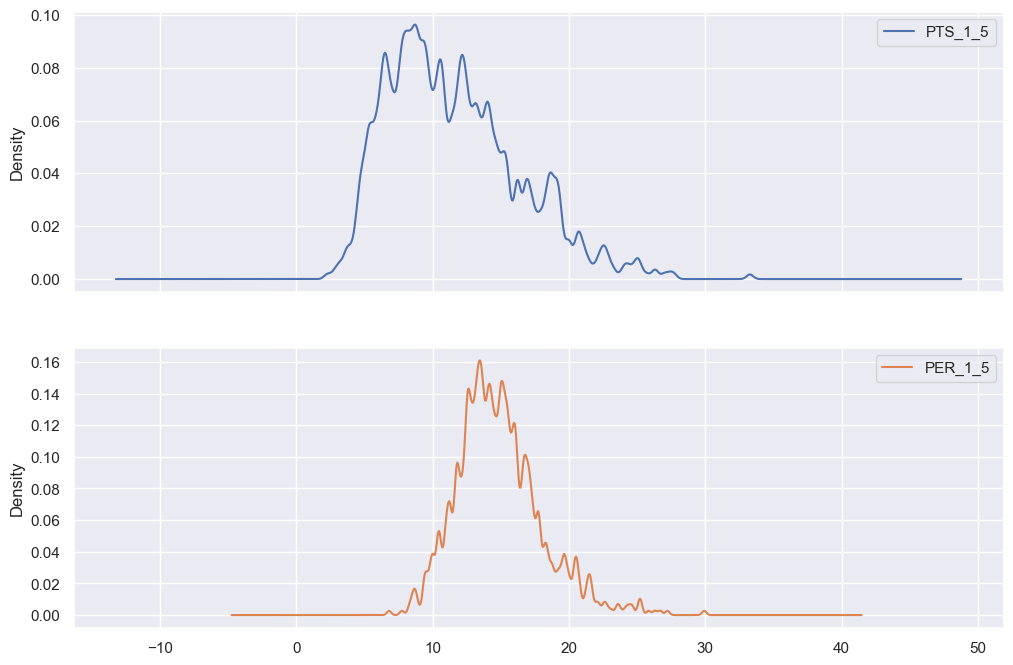

In [8]:
df_5[['PTS_1_5','PER_1_5']].plot.kde(figsize=(14,8), bw_method=0.05, layout=(2,1), subplots=True)

In [196]:
def get_outliers(att):
    q1 = df[att].quantile(0.25)
    q3 = df[att].quantile(0.75)
    IQR = q3 - q1
    upper_bound = q3 + 1.5 * IQR
    print(upper_bound)
    return df[df[att] > upper_bound]

get_outliers('PTS_1_5')

24.259999999999998


ID             Player  Seasons_played  Pos_PG_1_5  Pos_SG_1_5  \
27    123    Carmelo Anthony              18           0           0   
80    374         Larry Bird              10           0           0   
229  1200        Luka Dončić               7           1           0   
245  1274       Kevin Durant              17           0           0   
256  1358        Joel Embiid               9           0           0   
408  2227      Allen Iverson              14           0           1   
417  2286       LeBron James              22           0           0   
451  2479     Michael Jordan              14           0           1   
521  2929        Karl Malone              19           0           0   
623  3521   Shaquille O'Neal              19           0           0   
722  4003     David Robinson              13           0           0   
853  4815    Kiki Vandeweghe              11           0           0   
900  5077  Dominique Wilkins              14           0           0   
938  5291         Trae Young               7           1           0   

     Pos_SF_1_5  Pos_PF_1_5  Pos_C_1_5  G_1_5  GS_1_5  MP_1_5  FG_1_5  \
27            1           0          0   75.8    75.8   36.54    8.86   
80            0           1          0   79.4    74.4   38.30    9.90   
229           0           0          0   66.0    66.0   34.34    9.42   
245           1           0          0   76.0    76.0   38.12    8.94   
256           0           0          1   52.0    52.0   30.00    8.04   
408           0           0          0   69.0    68.6   40.76    9.30   
417           1           0          0   78.2    78.0   41.14    9.88   
451           0           0          0   81.8    81.8   39.58   12.22   
521           0           1          0   81.4    80.4   36.32    9.36   
623           0           0          1   69.2    68.8   37.76   10.88   
722           0           0          1   78.8    78.4   38.34    9.00   
853           0           1          0   78.6    74.6   34.90    9.62   
900           1           0          0   80.2    80.2   36.70    9.62   
938           0           0          0   70.6    70.6   33.92    8.18   

     FGA_1_5  FG%_1_5  3P_1_5  3PA_1_5  3P%_1_5  2P_1_5  2PA_1_5  2P%_1_5  \
27     19.12    0.461    0.66     2.20    0.291    8.20    16.92    0.483   
80     19.64    0.503    0.46     1.32    0.319    9.44    18.34    0.514   
229    20.24    0.464    2.78     8.26    0.338    6.64    11.96    0.552   
245    19.12    0.468    1.50     4.10    0.362    7.46    15.02    0.497   
256    16.52    0.485    1.12     3.42    0.337    6.88    13.12    0.523   
408    21.94    0.426    1.36     4.20    0.318    7.96    17.72    0.452   
417    21.16    0.466    1.32     4.04    0.322    8.58    17.10    0.500   
451    23.64    0.519    0.34     1.24    0.228   11.88    22.38    0.533   
521    17.84    0.522    0.06     0.18    0.137    9.34    17.70    0.524   
623    18.88    0.575    0.00     0.04    0.100   10.86    18.86    0.576   
722    17.10    0.528    0.02     0.16    0.158    8.98    16.94    0.531   
853    17.54    0.548    0.10     0.36    0.239    9.50    17.18    0.553   
900    20.54    0.471    0.18     0.68    0.194    9.44    19.84    0.477   
938    18.66    0.436    2.54     7.22    0.349    5.66    11.46    0.491   

     eFG%_1_5  FT_1_5  FTA_1_5  FT%_1_5  ORB_1_5  DRB_1_5  TRB_1_5  AST_1_5  \
27      0.478    6.28     7.86    0.795     2.02     3.98     6.02     3.06   
80      0.515    4.76     5.44    0.874     2.34     8.14    10.46     6.32   
229     0.533    6.08     8.20    0.737     1.00     7.60     8.58     8.02   
245     0.506    6.86     7.84    0.875     0.90     5.76     6.66     2.84   
256     0.519    7.24     8.92    0.804     2.36     8.60    10.92     2.96   
408     0.457    6.36     8.56    0.742     1.14     2.92     4.06     5.52   
417     0.496    6.32     8.68    0.730     1.30     5.62     6.90     6.58   
451     0.527    8.44     9.96    0.848   

<Axes: xlabel='Pos', ylabel='count'>

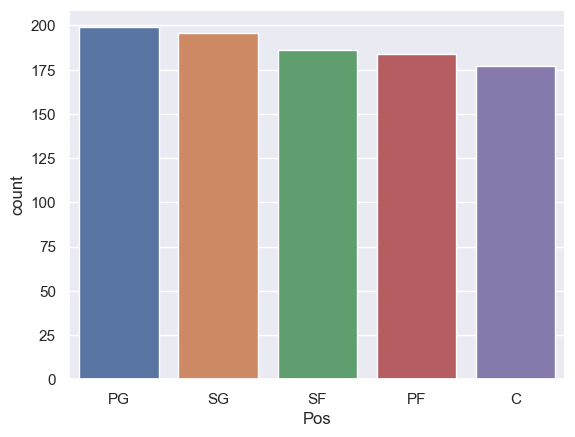

In [19]:
df_copy=df_5
conditions = [
    df_copy['Pos_PG_1_5'] == 1,
    df_copy['Pos_SG_1_5'] == 1,
    df_copy['Pos_SF_1_5'] == 1,
    df_copy['Pos_PF_1_5'] == 1,
    df_copy['Pos_C_1_5'] == 1
]

choices = ['PG', 'SG', 'SF', 'PF', 'C']

df_copy['Pos'] = np.select(conditions, choices, default='Unknown')

sns.countplot(x='Pos', data=df_copy, order=choices)

<Figure size 200x200 with 0 Axes>

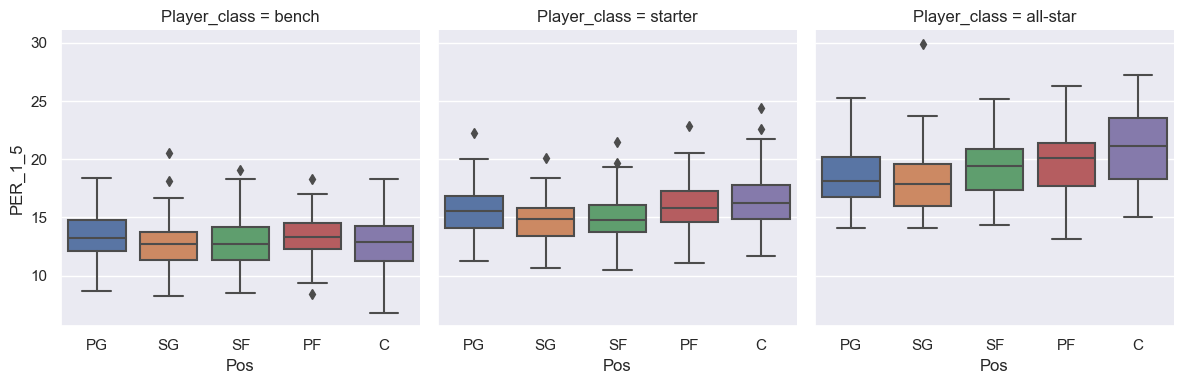

In [18]:
sns.catplot(x='Pos', y='PER_1_5', col='Player_class', data=df_copy, kind='box', height=4, order=['PG', 'SG', 'SF', 'PF', 'C'])

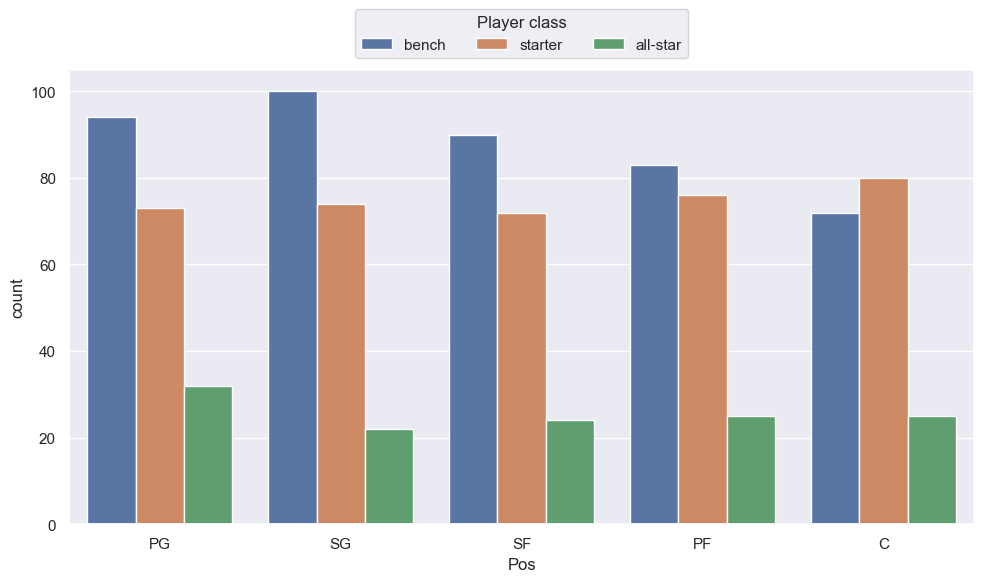

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Pos', hue='Player_class', data=df_copy, order=['PG', 'SG', 'SF', 'PF', 'C'])

plt.legend(title='Player class', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)
plt.tight_layout()
plt.show()

<h3>Function for extracting features highly correlated with the target variable

In [6]:
def select_high_corr_features(df, threshold=0.4):
    corr_matrix = df.corr(numeric_only=True)

    class_corr = corr_matrix['Player_class_num'].drop('Player_class_num')

    strong_corr_features = class_corr[abs(class_corr) > threshold].index.tolist()

    print(f'Number of attributes with high correlation with \'Player_class_num\' is {len(strong_corr_features)}.')

    strong_corr_features.append('Player_class_num')

    strong_corr_matrix = corr_df[strong_corr_features].corr()

    plt.figure(figsize=(14, 10))
    sns.heatmap(strong_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation matrix of attributes with |corr| > 0.4")
    plt.tight_layout()
    plt.show()
    
    return strong_corr_features

<h3>Function for identifying pairs of mutually highly correlated features

In [7]:
def get_high_corr_pairs(df, features, threshold=0.9):
    corr_matrix = df[features].corr()

    corr_pairs = (
        corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        .stack()
        .reset_index()
    )
    corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

    high_corr_pairs = corr_pairs[abs(corr_pairs['Correlation']) > threshold].sort_values(by='Correlation', ascending=False)
    
    return high_corr_pairs

Number of attributes with high correlation with 'Player_class_num' is 23.


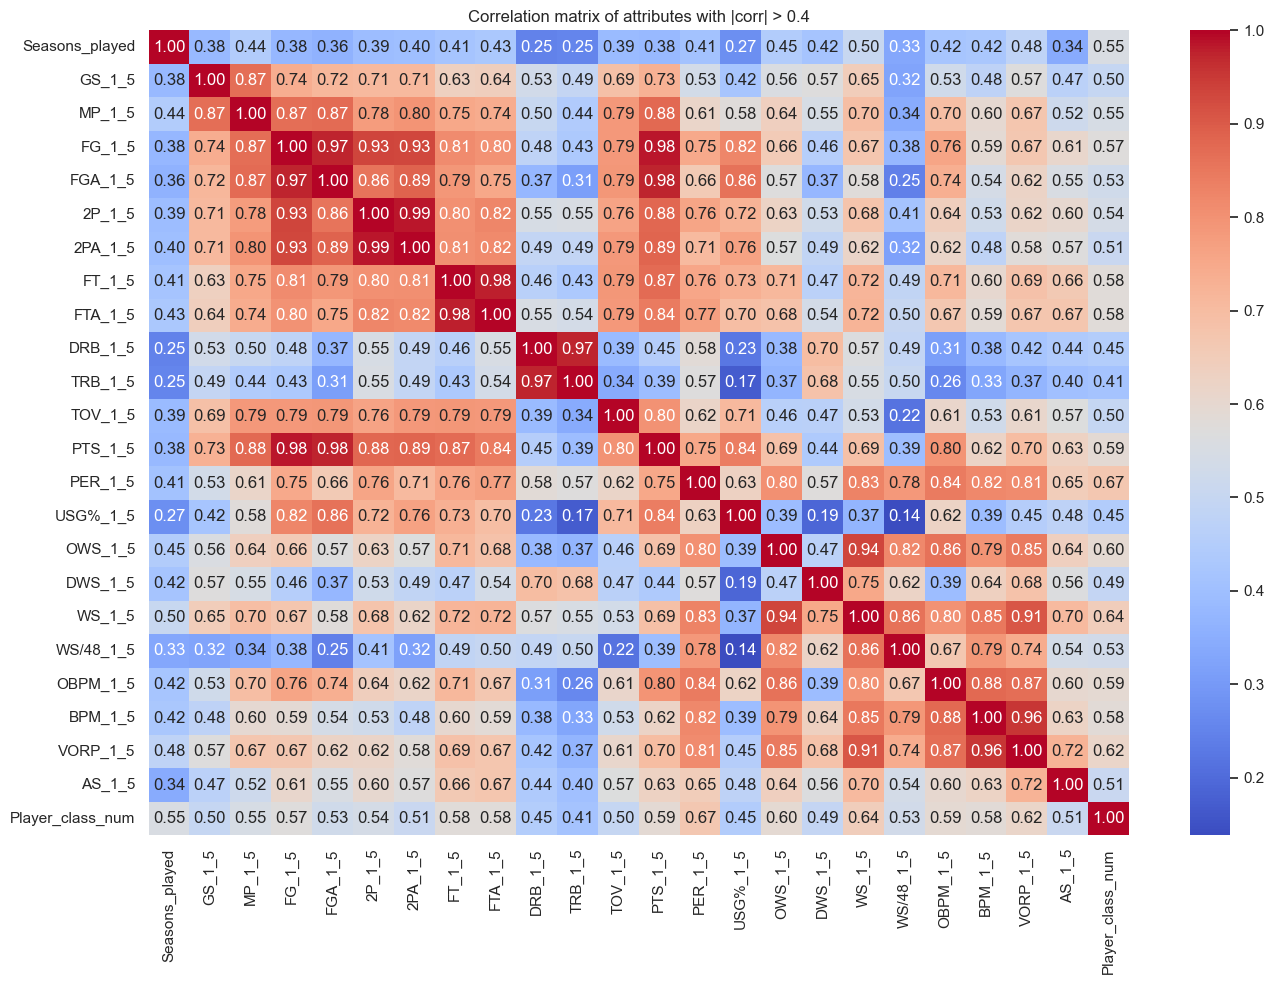

Feature_1 Feature_2  Correlation
105    2P_1_5   2PA_1_5     0.985174
74     FG_1_5   PTS_1_5     0.983600
140    FT_1_5   FTA_1_5     0.978946
93    FGA_1_5   PTS_1_5     0.976126
171   DRB_1_5   TRB_1_5     0.973545
66     FG_1_5   FGA_1_5     0.973373
270   BPM_1_5  VORP_1_5     0.955338
241   OWS_1_5    WS_1_5     0.935006
67     FG_1_5    2P_1_5     0.933122
68     FG_1_5   2PA_1_5     0.930366
258    WS_1_5  VORP_1_5     0.907179

In [8]:
class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_5['Player_class_num'] = df_5['Player_class'].map(class_mapping)

corr_df = df_5.drop(columns=['ID'])
strong_corr_features = select_high_corr_features(corr_df)
high_corr_pairs = get_high_corr_pairs(corr_df, strong_corr_features)
high_corr_pairs

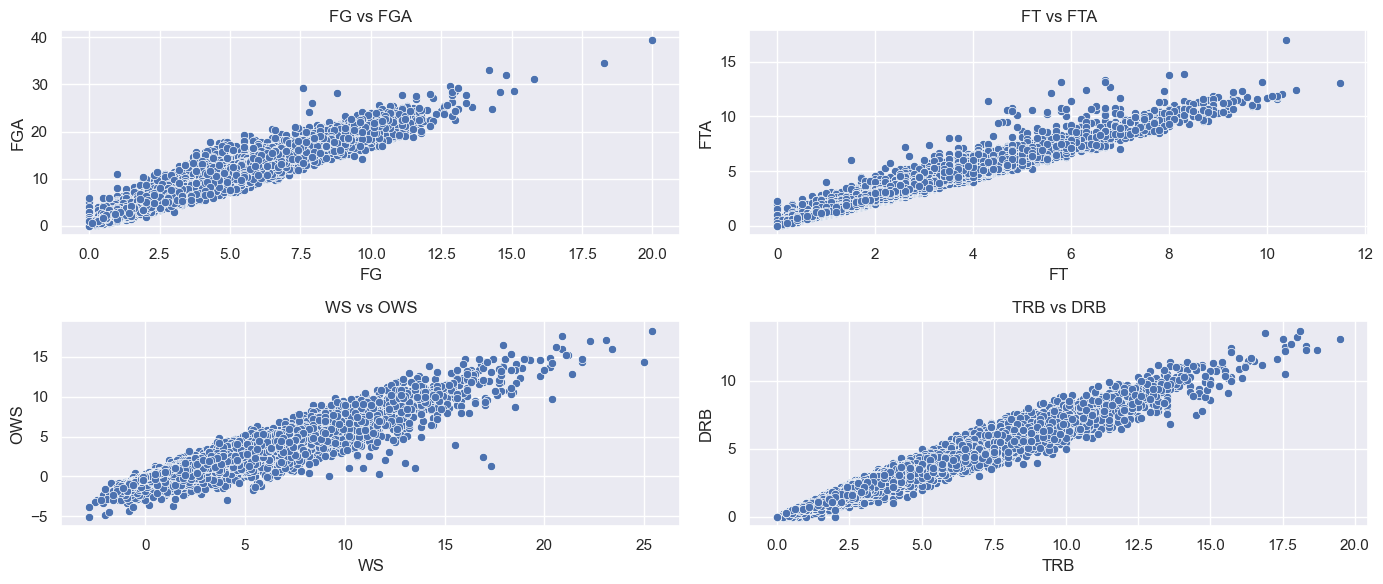

In [165]:
attr1 = 'FG'
attr2 = 'FGA'
attr3 = 'FT'
attr4 = 'FTA'
attr5 = 'WS'
attr6 = 'OWS'
attr7 = 'TRB'
attr8 = 'DRB'

fig, axes = plt.subplots(2, 2, figsize=(14, 6))

sns.scatterplot(data=df, x=attr1, y=attr2, ax=axes[0, 0])
axes[0, 0].set_title(f'{attr1} vs {attr2}')
axes[0, 0].set_xlabel(attr1)
axes[0, 0].set_ylabel(attr2)

sns.scatterplot(data=df, x=attr3, y=attr4, ax=axes[0, 1])
axes[0, 1].set_title(f'{attr3} vs {attr4}')
axes[0, 1].set_xlabel(attr3)
axes[0, 1].set_ylabel(attr4)

sns.scatterplot(data=df, x=attr5, y=attr6, ax=axes[1, 0])
axes[1, 0].set_title(f'{attr5} vs {attr6}')
axes[1, 0].set_xlabel(attr5)
axes[1, 0].set_ylabel(attr6)

sns.scatterplot(data=df, x=attr7, y=attr8, ax=axes[1, 1])
axes[1, 1].set_title(f'{attr7} vs {attr8}')
axes[1, 1].set_xlabel(attr7)
axes[1, 1].set_ylabel(attr8)

plt.tight_layout()
plt.show()

In [26]:
features_to_drop = set(["2PA_1_5", "FTA_1_5", "FGA_1_5", "DRB_1_5", "OWS_1_5", "2P_1_5", "VORP_1_5", "OBPM_1_5"])

selected_features = [feature for feature in strong_corr_features if feature not in features_to_drop]

In [27]:
selected_features

['Seasons_played',
 'GS_1_5',
 'MP_1_5',
 'FG_1_5',
 'FT_1_5',
 'TRB_1_5',
 'TOV_1_5',
 'PTS_1_5',
 'PER_1_5',
 'USG%_1_5',
 'DWS_1_5',
 'WS_1_5',
 'WS/48_1_5',
 'BPM_1_5',
 'AS_1_5',
 'Player_class_num']

In [28]:
len(selected_features)

16

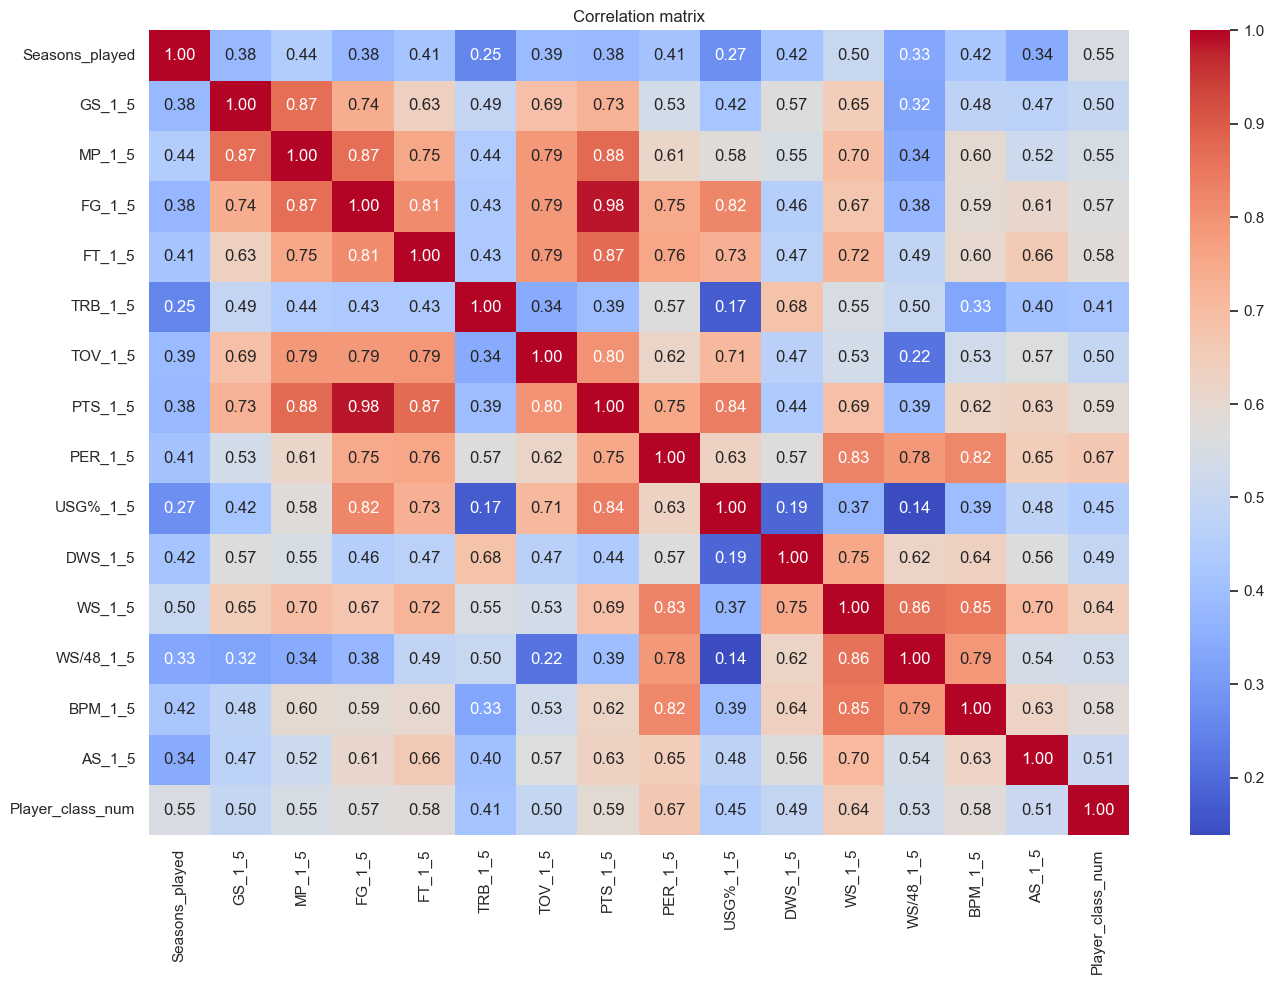

In [19]:
class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_5['Player_class_num'] = df_5['Player_class'].map(class_mapping)

final_dataset_5_seasons = df_5[get_selected_features(5)]

corr_5_seasons = final_dataset_5_seasons.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_5_seasons, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

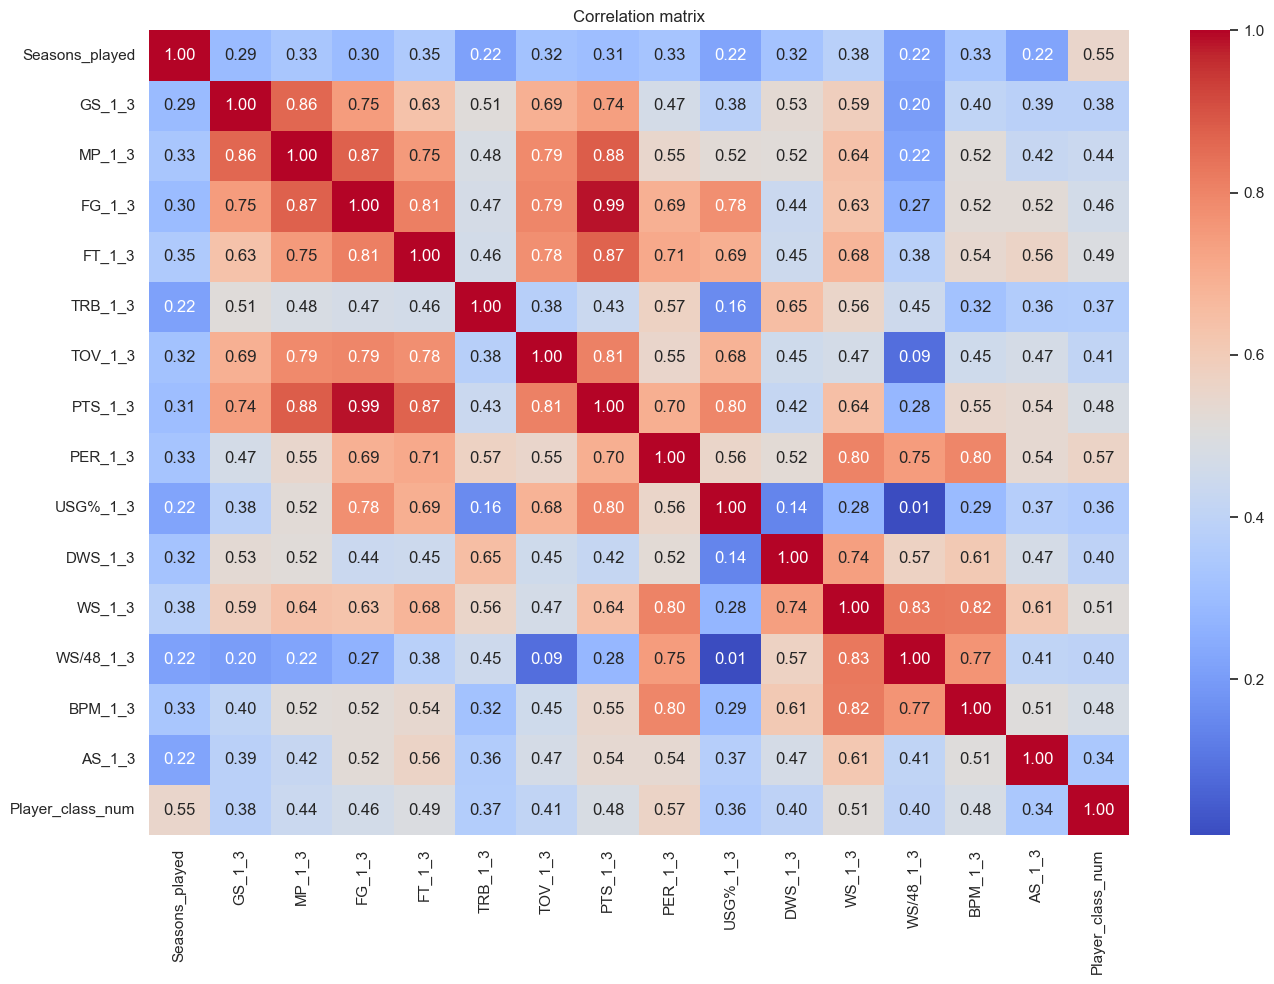

In [17]:
class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_3['Player_class_num'] = df_3['Player_class'].map(class_mapping)

final_dataset_3_seasons = df_3[get_selected_features(3)]

corr_3_seasons = final_dataset_3_seasons.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_3_seasons, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

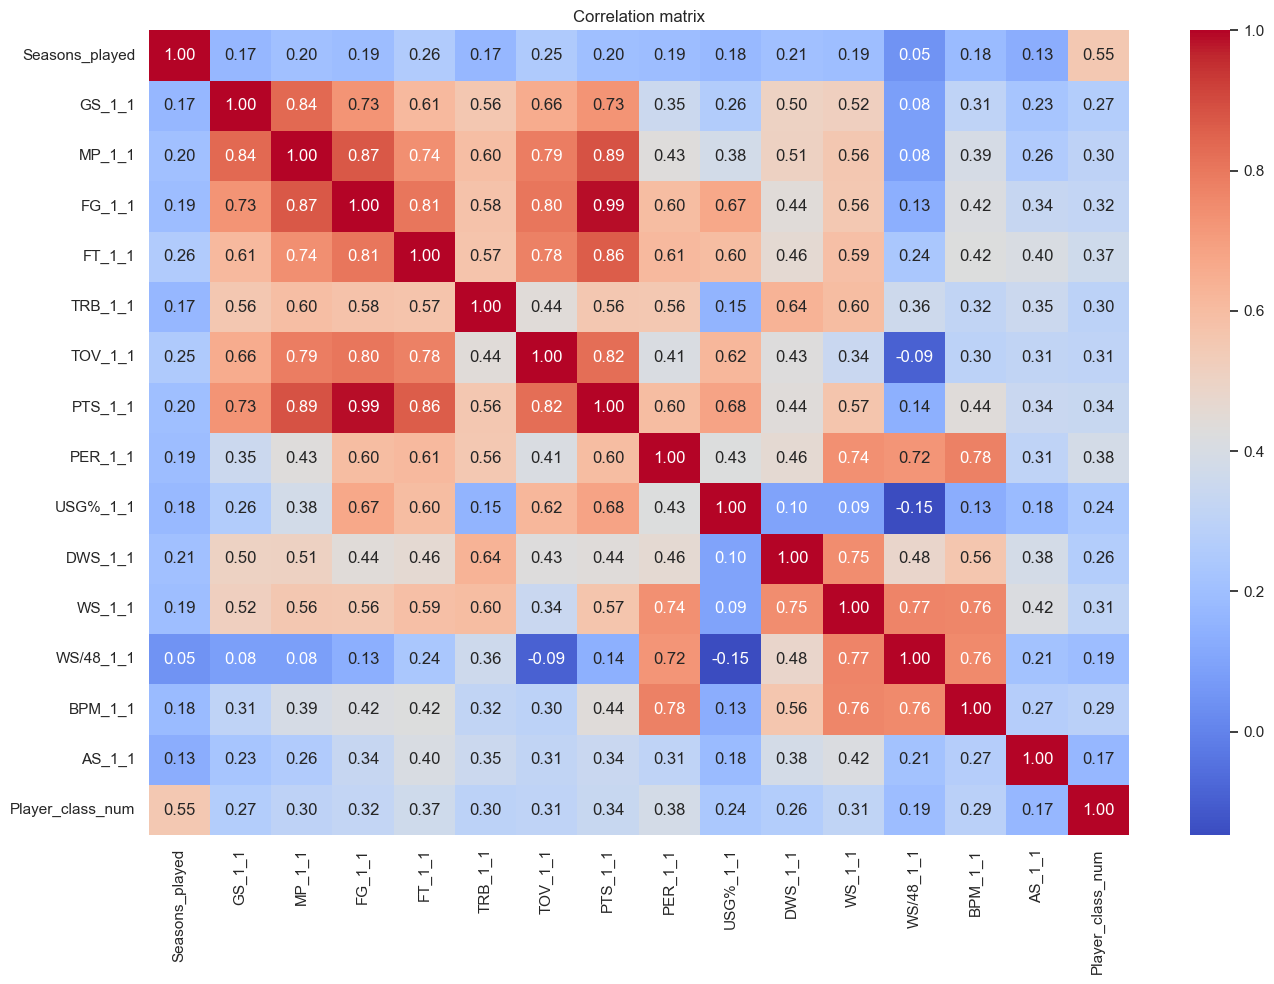

In [20]:
class_mapping = {'bench': 0, 'starter': 1, 'all-star': 2}
df_1['Player_class_num'] = df_1['Player_class'].map(class_mapping)

final_dataset_1_seasons = df_1[get_selected_features(1)]

corr_1_seasons = final_dataset_1_seasons.corr(numeric_only=True)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_1_seasons, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation matrix")
plt.tight_layout()
plt.show()

Best params: {'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 50, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
=== Classification Report ===
               precision    recall  f1-score   support

           0       0.70      0.82      0.75        88
           1       0.63      0.56      0.59        75
           2       0.84      0.62      0.71        26

    accuracy                           0.69       189
   macro avg       0.72      0.66      0.69       189
weighted avg       0.69      0.69      0.68       189


=== ROC AUC value ===
 0.8736561866862029


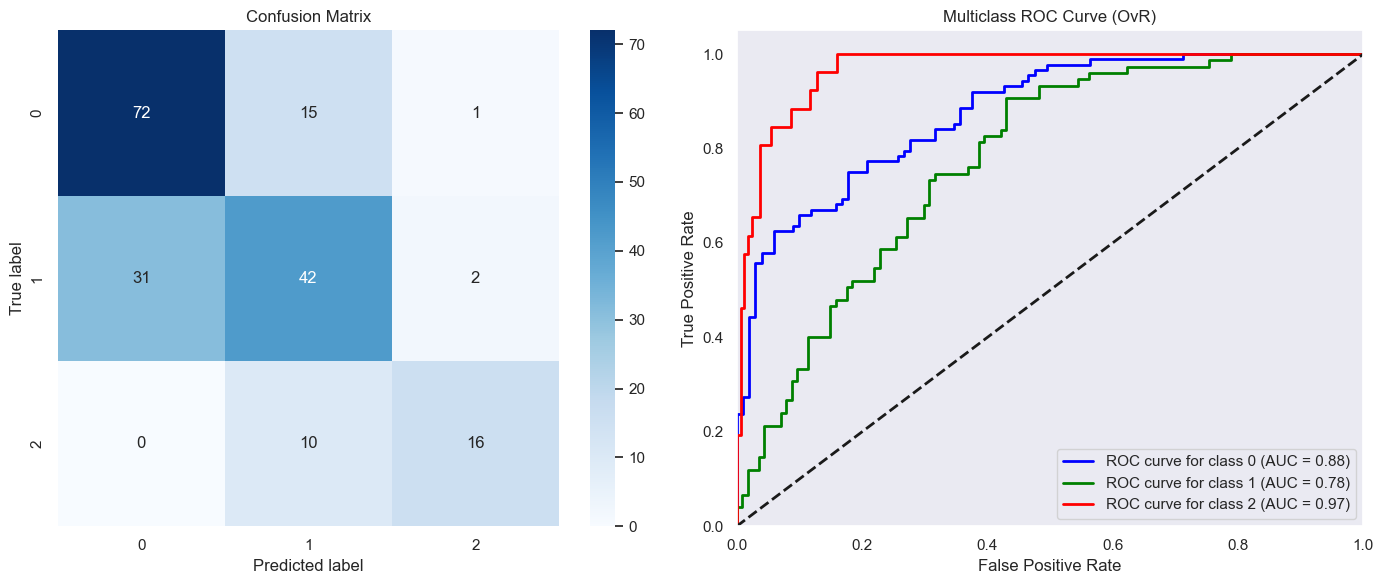

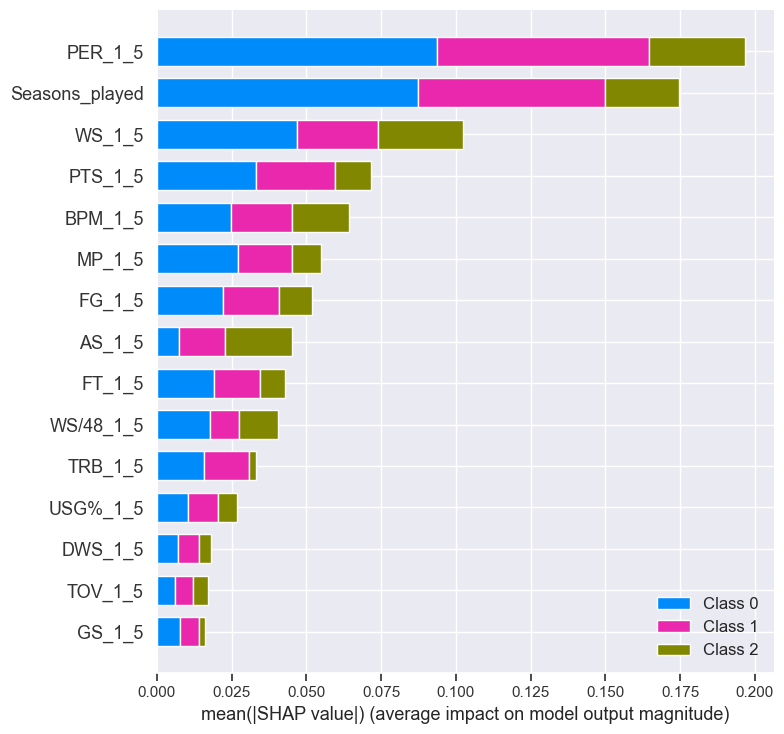

In [366]:
# Treniranje Random Forest modela
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_leaf_nodes': [10, 20, 25, 30],
    'max_features': ['sqrt', 10, 15]
}

roc_auc_macro = make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True)

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring=roc_auc_macro,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

calculate_evaluation_metrics(best_model, y_test, y_pred, y_pred_proba)
display_shap_lime_plots(best_model, X_train, X_test, 0)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=adam; total time=   5.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=adam; total time=   5.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=adam; total time=   5.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=adam; total time=   6.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64], clf__mo

[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   6.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   6.4s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   6.8s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   6.9s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__

[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   5.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   5.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   6.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   5.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__

[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   5.5s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   6.0s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   5.6s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   5.7s
[CV] END clf__batch_size=32, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__mo

[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.5s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.6s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.9s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.6s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=relu, clf__model__hidden_layers=[64, 32], clf__model__input_dim=15, clf__model__

[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=adam; total time=   4.4s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.1s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.2s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[64], clf__model__input_dim=15, clf__model__num_classes=3, clf__mod

[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=adam; total time=   5.3s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=adam; total time=   5.3s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.7s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__num_classes=3, clf__model__optimizer=rmsprop; total time=   4.7s
[CV] END clf__batch_size=64, clf__epochs=50, clf__model__activation=tanh, clf__model__hidden_layers=[128, 64], clf__model__input_dim=15, clf__model__n

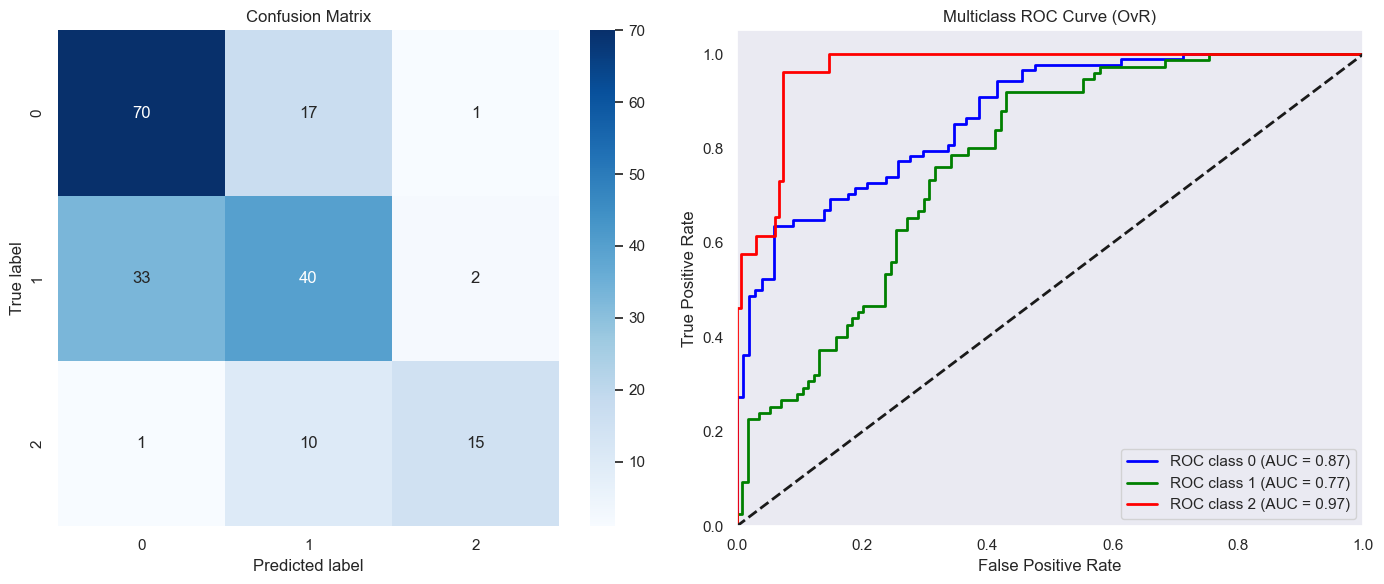

In [184]:
num_classes = len(np.unique(y_train))

keras_clf = KerasClassifier(
    model=create_model,
    verbose=0
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', keras_clf)
])

param_grid = {
    'clf__model__input_dim': [X_train.shape[1]],
    'clf__model__num_classes': [num_classes],
    'clf__model__hidden_layers': [[64], [64, 32], [128, 64]],
    'clf__model__activation': ['relu', 'tanh'],
    'clf__model__optimizer': ['adam', 'rmsprop'],
    'clf__batch_size': [32, 64],
    'clf__epochs': [50]
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='accuracy', 
    verbose=2)

grid_result = grid.fit(X_train, y_train)
best_model = grid_result.best_estimator_

y_pred_proba = best_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

calculate_evaluation_metrics(best_model.named_steps['clf'].model, y_test, y_pred, y_pred_proba)

In [186]:
best_model.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 KerasClassifier(batch_size=32, epochs=50, model=<function create_model at 0x0000016ED2863100>, model__activation='tanh', model__hidden_layers=[64], model__input_dim=15, model__num_classes=3, model__optimizer='adam', verbose=0))])>